
**University of Malaya**

**Faculty of Computer Science & Information Technology**

**WIA1006 Machine Learning**

**Group Project Assignment 2023_24**


```
Group 67
Dennis Aimin Oon bin Jeffrey Oon - 22001610
Adib Rusyaidi Bin Mohd Zaki - 22001821
Irfan Najmi bin Khairunizam - 22002077
Muhammad Hadif Amar bin Razali - 23005018
Muhammad Imran bin Ilias - 22001723
```


# 1.0 Data Preprocessing

## 1.1 Data Loading


In [1]:
# Import necessary librabries
import pandas as pd
import numpy as np

# Reads multiple CSV files containing resale flat price data from different periods (from 1990 to 2017) into separate pandas DataFrame objects
resaleflat1 = pd.read_csv('Resale flat prices based on registration date from Jan-2017 onwards.csv')
resaleflat2 = pd.read_csv('Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv')
resaleflat3 = pd.read_csv('Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv')
resaleflat4 = pd.read_csv('Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv')
resaleflat5 = pd.read_csv('Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv')

# Concatenates these DataFrames along the rows (axis=0) into a single DataFrame named 'df'
df = pd.concat((resaleflat1,resaleflat2,resaleflat3,resaleflat4,resaleflat5), axis=0, sort=True)

# Create a copy of 'df' for various data manipulation tasks later without altering the original data
df_1 = df.copy()

# Read another CSV file about street to MRT in Singapore into a DataFrame named locations
locations = pd.read_csv('street_to_MRT.csv')

# Drops an unnamed column from this DataFrame
locations = locations.drop('Unnamed: 0', axis=1)

Datasets that we are using in our project is about Resale Flat Prices in Singapore and MRT locations around Singapore.

## 1.2 Initial Data Exploration

In [2]:
# Display the first 5 rows of the main dataset to get an initial sense of the data.
df.head(5)

block      flat_model flat_type  floor_area_sqm  lease_commence_date  \
0   406        Improved    2 ROOM            44.0                 1979   
1   108  New Generation    3 ROOM            67.0                 1978   
2   602  New Generation    3 ROOM            67.0                 1980   
3   465  New Generation    3 ROOM            68.0                 1980   
4   601  New Generation    3 ROOM            67.0                 1980   

     month     remaining_lease  resale_price storey_range        street_name  \
0  2017-01  61 years 04 months      232000.0     10 TO 12  ANG MO KIO AVE 10   
1  2017-01  60 years 07 months      250000.0     01 TO 03   ANG MO KIO AVE 4   
2  2017-01  62 years 05 months      262000.0     01 TO 03   ANG MO KIO AVE 5   
3  2017-01   62 years 01 month      265000.0     04 TO 06  ANG MO KIO AVE 10   
4  2017-01  62 years 05 months      265000.0     01 TO 03   ANG MO KIO AVE 5   

         town  
0  ANG MO KIO  
1  ANG MO KIO  
2  ANG MO KIO  
3  ANG MO KIO  
4  ANG MO KIO

In [3]:
# Display the first 5 rows of the MRT locations dataset to get an initial sense of the data.
locations.head(5)

street_name  dist_nearestMRT
0         CIRCUIT RD         0.435332
1  JURONG EAST ST 21         0.567413
2  JURONG EAST ST 24         0.738477
3  JURONG EAST ST 21         0.884302
4  JURONG EAST ST 21         0.884302

In [4]:
# Ensure each street name appears only once in the DataFrame locations, removing any duplicate entries based on the 'street_name' column.
locations = locations[-locations.duplicated(keep='first',subset='street_name')]

In [5]:
# Merge the main DataFrame and locations DataFrame.
df_1 = pd.merge(df,locations,how='left')

The above codes will effectively adds location information to the resale flat price data, linking each flat to its corresponding street and potentially its nearby MRT station.

In [6]:
# Shows data types and non-null values for every columns.
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924719 entries, 0 to 924718
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   block                924719 non-null  object 
 1   flat_model           924719 non-null  object 
 2   flat_type            924719 non-null  object 
 3   floor_area_sqm       924719 non-null  float64
 4   lease_commence_date  924719 non-null  int64  
 5   month                924719 non-null  object 
 6   remaining_lease      215669 non-null  object 
 7   resale_price         924719 non-null  float64
 8   storey_range         924719 non-null  object 
 9   street_name          924719 non-null  object 
 10  town                 924719 non-null  object 
 11  dist_nearestMRT      911911 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 84.7+ MB


From df_1.info(), we knew the total features and samples we have.
* The dataset has 924719 samples, or rows of observation with 11 columns.
* Have 10 features determining 1 target output (resale_price)
* 10 features is good enough
* Resale Price data has enough samples

From df.info(), we knew the features data type.

int 64
* lease_commence_date

float64
* floor_area_sqm
* resale_price
* dist_nearestMRT

object
* block
* flat_model
* flat_type
* month
* remaining_lease
* storage_range
* street_name
* town

In [7]:
# Shows the total number of missing values per column.
df_1.isnull().sum()

block                       0
flat_model                  0
flat_type                   0
floor_area_sqm              0
lease_commence_date         0
month                       0
remaining_lease        709050
resale_price                0
storey_range                0
street_name                 0
town                        0
dist_nearestMRT         12808
dtype: int64

From df.isna().sum(), we know the amount of null values in each column in the dataframe.


*   remaining_lease column have 709050 total null values
*   dist_nearestMRT column have 12808 total null values
*   All other columns have no null values


We have a lots of missing values in remaining_lease column because dataset for Resale Flat Price 1990-2014 have no remaining_lease column.

We will fill in these missing values by calculating with lease_commence_date and month columns later on.

For dist_nearestMRT, we will fill in the missing values with an assumption later on.

In [8]:
# Correlation analysis

# Select only numeric columns
numeric_columns = df_1.select_dtypes(include=['number'])

# Compute the correlation matrix
numeric_columns.corr()

floor_area_sqm  lease_commence_date  resale_price  \
floor_area_sqm             1.000000             0.387511      0.564117   
lease_commence_date        0.387511             1.000000      0.537526   
resale_price               0.564117             0.537526      1.000000   
dist_nearestMRT            0.096042             0.098420      0.022053   

                     dist_nearestMRT  
floor_area_sqm              0.096042  
lease_commence_date         0.098420  
resale_price                0.022053  
dist_nearestMRT             1.000000

numeric_columns.corr() shows the strength and direction of the correlation between two columns in the dataframe.
*   The number shows the strength of the correlation or the gradient if we were to graph the values in the two columns

In [9]:
# Shows the missing values in Boolean.
df_1.isna()

block  flat_model  flat_type  floor_area_sqm  lease_commence_date  \
0       False       False      False           False                False   
1       False       False      False           False                False   
2       False       False      False           False                False   
3       False       False      False           False                False   
4       False       False      False           False                False   
...       ...         ...        ...             ...                  ...   
924714  False       False      False           False                False   
924715  False       False      False           False                False   
924716  False       False      False           False                False   
924717  False       False      False           False                False   
924718  False       False      False           False                False   

        month  remaining_lease  resale_price  storey_range  street_name  \
0       False            False         False         False        False   
1       False            False         False         False        False   
2       False            False         False         False        False   
3       False            False         False         False        False   
4       False            False         False         False        False   
...       ...              ...           ...           ...          ...   
924714  False             True         False         False        False   
924715  False             True         False         False        False   
924716  False             True         False         False        False   
924717  False             True         False         False        False   
924718  False             True         False         False        False   

         town  dist_nearestMRT  
0       False            False  
1       False            False  
2       False            False  
3       False            False  
4       False            False  
...       ...              ...  
924714  False            False  
924715  False            False  
924716  False            False  
924717  False            False  
924718  False            False  

[924719 rows x 12 columns]

df_1.isna() shows whether there are missing values or not in each column in a row.

*   False means that there are no missing values in the column in the row.

*   True means there are missing values in the column in the row.

In [10]:
# Shows summary statistics (e.g., min, max, mean, std deviation, and quartiles).
df_1.describe()

floor_area_sqm  lease_commence_date  resale_price  dist_nearestMRT
count   924719.000000        924719.000000  9.247190e+05    911911.000000
mean        95.692190          1988.250031  3.200048e+05         0.786746
std         25.829001            10.635959  1.697678e+05         0.424307
min         28.000000          1966.000000  5.000000e+03         0.035610
25%         73.000000          1981.000000  1.930000e+05         0.462378
50%         93.000000          1986.000000  2.960000e+05         0.675676
75%        113.000000          1996.000000  4.160000e+05         1.047701
max        307.000000          2022.000000  1.568888e+06         5.495654

df_1.describe() returns the description of the data in each column in the dataframe.
*   count gives the total amount of data in each columns
*   mean gives the average value of the whole column for each columns
*   std gives the standard deviation of each value in the column for each columns
*   min gives the lowest value in each columns
*   25% gives the number of values lower than 25% percentile of the column
*   50% gives the number of values lower than 50% percentile of the column
*   75% gives the number of values lower than 75% percentile of the column
*   max gives the highest value in each columns

## 1.3 Data Cleaning

### 1.3.1 Changes to the dataframe to make it understandable

In [11]:
# Understanding the different categories of flat models.
df_1["flat_model"].unique()

array(['Improved', 'New Generation', 'DBSS', 'Standard', 'Apartment',
       'Simplified', 'Model A', 'Premium Apartment', 'Adjoined flat',
       'Model A-Maisonette', 'Maisonette', 'Type S1', 'Type S2',
       'Model A2', 'Terrace', 'Improved-Maisonette', 'Premium Maisonette',
       'Multi Generation', 'Premium Apartment Loft', '2-room', '3Gen',
       'IMPROVED', 'NEW GENERATION', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', 'TERRACE',
       '2-ROOM', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT'], dtype=object)

In [12]:
# Clean flat model column by capitalising and renaming

df_1["flat_model"] = df_1["flat_model"].replace("Improved", "IMPROVED")
df_1["flat_model"] = df_1["flat_model"].replace("New Generation", "NEW GENERATION")
df_1["flat_model"] = df_1["flat_model"].replace("Standard", "STANDARD")
df_1["flat_model"] = df_1["flat_model"].replace("Apartment", "APARTMENT")
df_1["flat_model"] = df_1["flat_model"].replace("Simplified", "SIMPLIFIED")
df_1["flat_model"] = df_1["flat_model"].replace("Model A", "MODEL A")
df_1["flat_model"] = df_1["flat_model"].replace("Premium Apartment", "PREMIUM APARTMENT")
df_1["flat_model"] = df_1["flat_model"].replace("Adjoined flat", "ADJOINED FLAT")
df_1["flat_model"] = df_1["flat_model"].replace("Model A-Maisonette", "MODEL A MAISONETTE")
df_1["flat_model"] = df_1["flat_model"].replace("Maisonette", "MAISONETTE")
df_1["flat_model"] = df_1["flat_model"].replace("Type S1", "TYPE S1")
df_1["flat_model"] = df_1["flat_model"].replace("Type S2", "TYPE S2")
df_1["flat_model"] = df_1["flat_model"].replace("Model A2", "MODEL A2")
df_1["flat_model"] = df_1["flat_model"].replace("Terrace", "TERRACE")
df_1["flat_model"] = df_1["flat_model"].replace("Improved-Maisonette", "IMPROVED MAISONETTE")
df_1["flat_model"] = df_1["flat_model"].replace("Premium Maisonette", "PREMIUM MAISONETTE")
df_1["flat_model"] = df_1["flat_model"].replace("Multi Generation", "MULTI-GENERATION")
df_1["flat_model"] = df_1["flat_model"].replace("Premium Apartment Loft", "PREMIUM APARTMENT LOFT")
df_1["flat_model"] = df_1["flat_model"].replace("2-room", "2 ROOM")
df_1["flat_model"] = df_1["flat_model"].replace("3Gen", "3 GEN")
df_1["flat_model"] = df_1["flat_model"].replace("MODEL A-MAISONETTE", "MODEL A MAISONETTE")
df_1["flat_model"] = df_1["flat_model"].replace("2-ROOM", "2 ROOM")
df_1["flat_model"] = df_1["flat_model"].replace("IMPROVED-MAISONETTE", "IMPROVED MAISONETTE")
df_1["flat_model"] = df_1["flat_model"].replace("MULTI GENERATION", "MULTI-GENERATION")

df_1["flat_model"].unique()

array(['IMPROVED', 'NEW GENERATION', 'DBSS', 'STANDARD', 'APARTMENT',
       'SIMPLIFIED', 'MODEL A', 'PREMIUM APARTMENT', 'ADJOINED FLAT',
       'MODEL A MAISONETTE', 'MAISONETTE', 'TYPE S1', 'TYPE S2',
       'MODEL A2', 'TERRACE', 'IMPROVED MAISONETTE', 'PREMIUM MAISONETTE',
       'MULTI-GENERATION', 'PREMIUM APARTMENT LOFT', '2 ROOM', '3 GEN'],
      dtype=object)

Ensured there are no duplicated categories and looks more neatly & readable

In [13]:
df_1["flat_type"].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION', 'MULTI GENERATION'], dtype=object)

In [14]:
# Combine MULTI-GENERATION and MULTI GENERATION categories in flat type
df_1["flat_type"] = df_1["flat_type"].replace("MULTI GENERATION", "MULTI-GENERATION")
df_1["flat_type"].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

Ensured there are no duplicated categories and looks more neatly & readable

In [15]:
# Get the latest sense of the data.
df_1.head(5)

block      flat_model flat_type  floor_area_sqm  lease_commence_date  \
0   406        IMPROVED    2 ROOM            44.0                 1979   
1   108  NEW GENERATION    3 ROOM            67.0                 1978   
2   602  NEW GENERATION    3 ROOM            67.0                 1980   
3   465  NEW GENERATION    3 ROOM            68.0                 1980   
4   601  NEW GENERATION    3 ROOM            67.0                 1980   

     month     remaining_lease  resale_price storey_range        street_name  \
0  2017-01  61 years 04 months      232000.0     10 TO 12  ANG MO KIO AVE 10   
1  2017-01  60 years 07 months      250000.0     01 TO 03   ANG MO KIO AVE 4   
2  2017-01  62 years 05 months      262000.0     01 TO 03   ANG MO KIO AVE 5   
3  2017-01   62 years 01 month      265000.0     04 TO 06  ANG MO KIO AVE 10   
4  2017-01  62 years 05 months      265000.0     01 TO 03   ANG MO KIO AVE 5   

         town  dist_nearestMRT  
0  ANG MO KIO         0.497407  
1  ANG MO KIO         1.697526  
2  ANG MO KIO         0.752168  
3  ANG MO KIO         0.497407  
4  ANG MO KIO         0.752168

### 1.3.2 Handling incomplete data/missing values

In [16]:
# Calculate 75% percentile for the dist_nearestMRT column
percentile_75 = df_1['dist_nearestMRT'].quantile(0.75)
print("75% percentile for dist_nearestMRT:", percentile_75)

75% percentile for dist_nearestMRT: 1.04770075033


In [17]:
# Input 75% percentile for dist_nearestMRT for missing values, assume that these streets are far away from MRT.
df_1['dist_nearestMRT'] = df_1['dist_nearestMRT'].fillna(1.04770075033)

**Note: Distance to nearest MRT alreadly normalized (0-3.53), dont need to normalize**

In [18]:
# Convert lease_commence_date to remaining lease at point of transaction
# lease commencing 1976 and sale in 1990 =  1976+99-1990 = 85 years remaining
# Report Section 4-A
df_1["remaining_lease"] = (df_1["lease_commence_date"] + 99 - df_1["month"].str[:4].astype(int))/99
df_1 = df_1.drop(columns=['lease_commence_date'])

In [19]:
# Check whether there are still have missing value
df_1.isna().sum()

block              0
flat_model         0
flat_type          0
floor_area_sqm     0
month              0
remaining_lease    0
resale_price       0
storey_range       0
street_name        0
town               0
dist_nearestMRT    0
dtype: int64

df_1.isna().sum() shows missing or null values in the dataframe.

No missing values are detected as they have been dropped in previous code.

### 1.3.3 Remove outliers

In [20]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924719 entries, 0 to 924718
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   block            924719 non-null  object 
 1   flat_model       924719 non-null  object 
 2   flat_type        924719 non-null  object 
 3   floor_area_sqm   924719 non-null  float64
 4   month            924719 non-null  object 
 5   remaining_lease  924719 non-null  float64
 6   resale_price     924719 non-null  float64
 7   storey_range     924719 non-null  object 
 8   street_name      924719 non-null  object 
 9   town             924719 non-null  object 
 10  dist_nearestMRT  924719 non-null  float64
dtypes: float64(4), object(7)
memory usage: 77.6+ MB


In [21]:
df_1.describe()

floor_area_sqm  remaining_lease  resale_price  dist_nearestMRT
count   924719.000000    924719.000000  9.247190e+05    924719.000000
mean        95.692190         0.819481  3.200048e+05         0.790360
std         25.829001         0.107998  1.697678e+05         0.422460
min         28.000000         0.414141  5.000000e+03         0.035610
25%         73.000000         0.747475  1.930000e+05         0.468097
50%         93.000000         0.838384  2.960000e+05         0.698541
75%        113.000000         0.909091  4.160000e+05         1.047701
max        307.000000         1.020202  1.568888e+06         5.495654

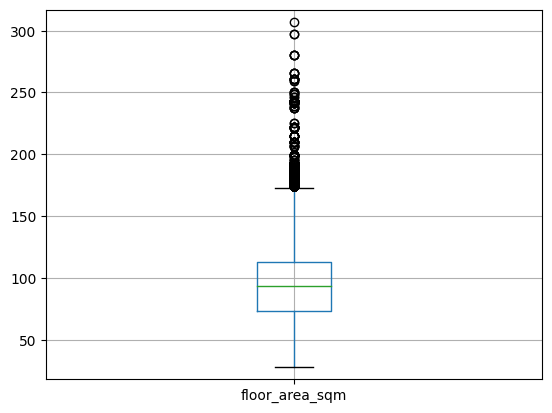

In [22]:
# We use boxplot to find outliers.
# Outliers are values that are higher or lower than most of the data.
import matplotlib.pyplot as plt

# Create a boxplot for the 'floor_area_sqm' column
ax = df_1.boxplot(column='floor_area_sqm')

# Set y-axis limits to cover the full range of the data
ax.set_ylim(min(df_1['floor_area_sqm']) - 10, max(df_1['floor_area_sqm']) + 10)

plt.show()

We plot the values in floor_area_sqm column in a boxplot to look for the outliers in the dataframe.

Outliers are values that strayed to far away from the rest of the values.

In [23]:
# Filter out data points with floor area 250 sqm and above.
large_floor_area_data = df_1[df_1['floor_area_sqm'] >= 250]

print(large_floor_area_data)

       block flat_model flat_type  floor_area_sqm    month  remaining_lease  \
181629    53    TERRACE    3 ROOM           280.0  2015-03         0.565657   
215006    57    TERRACE    3 ROOM           259.0  2016-12         0.555556   
240405    65    TERRACE    3 ROOM           266.0  2013-04         0.585859   
291945    57    TERRACE    3 ROOM           259.0  2000-09         0.717172   
291946    65    TERRACE    3 ROOM           266.0  2000-09         0.717172   
313242    54    TERRACE    3 ROOM           261.0  2001-04         0.707071   
351787    58    TERRACE    3 ROOM           297.0  2002-04         0.696970   
424219    53    TERRACE    3 ROOM           280.0  2004-08         0.676768   
451750    43    TERRACE    3 ROOM           261.0  2005-07         0.666667   
511612    42    TERRACE    3 ROOM           250.0  2007-09         0.646465   
514108    54    TERRACE    3 ROOM           261.0  2007-10         0.646465   
520648    65    TERRACE    3 ROOM           266.0  2

In [24]:
# Drop rows with floor_area_sqm >= 250 because these values strayed far away from the rest of the values.
outliers_area = df_1['floor_area_sqm'] >= 250
df_1.drop(df_1[outliers_area].index, inplace = True)

* 250 sqm approx. equals to 2690.98 sqft
* Removed these outliers to improving model performance

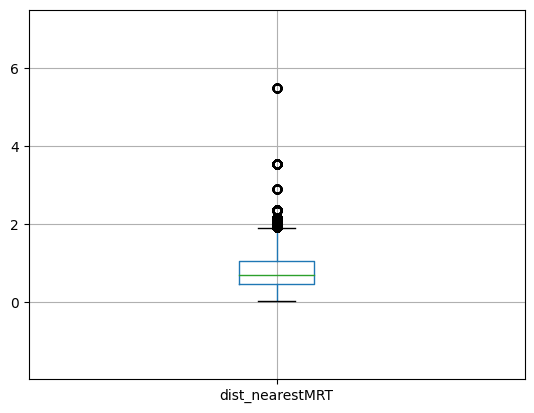

In [25]:
# We use boxplot to find outliers.
# Outliers are values that are higher or lower than most of the data.
import matplotlib.pyplot as plt

# Create a boxplot for the 'floor_area_sqm' column
ax = df_1.boxplot(column='dist_nearestMRT')

# Set y-axis limits to cover the full range of the data
ax.set_ylim(min(df_1['dist_nearestMRT']) - 2, max(df_1['dist_nearestMRT']) + 2)

plt.show()

We plot the values in dist_nearestMRT column in a boxplot to look for the outliers in the dataframe.

In [26]:
# Filter out data points with distance to nearest MRT 3.53 and above.
large_dist_nearestMRT_data = df_1[df_1['dist_nearestMRT'] >= 3.53]

print(large_dist_nearestMRT_data)

       block flat_model flat_type  floor_area_sqm    month  remaining_lease  \
670        5   IMPROVED    3 ROOM            66.0  2017-01         0.636364   
5159       4   IMPROVED    3 ROOM            66.0  2017-04         0.626263   
8911       1   IMPROVED    3 ROOM            77.0  2017-06         0.626263   
10629      5   IMPROVED    3 ROOM            66.0  2017-07         0.636364   
12535      5   IMPROVED    3 ROOM            66.0  2017-08         0.636364   
...      ...        ...       ...             ...      ...              ...   
849211     4   IMPROVED    3 ROOM            59.0  1998-09         0.818182   
854511     3   IMPROVED    3 ROOM            70.0  1998-10         0.818182   
859864     3   IMPROVED    3 ROOM            59.0  1998-11         0.818182   
859865     4   IMPROVED    4 ROOM            83.0  1998-11         0.818182   
864915     4   IMPROVED    3 ROOM            59.0  1998-12         0.818182   

        resale_price storey_range        street_nam

In [27]:
# Drop rows with dist_nearestMRT >= 3.53 because these values strayed far away from the rest of the values.
outliers_dist = df_1['dist_nearestMRT'] >= 3.53
df_1.drop(df_1[outliers_dist].index, inplace = True)

In [28]:
# See the latest sense of data
df_1.head()

block      flat_model flat_type  floor_area_sqm    month  remaining_lease  \
0   406        IMPROVED    2 ROOM            44.0  2017-01         0.616162   
1   108  NEW GENERATION    3 ROOM            67.0  2017-01         0.606061   
2   602  NEW GENERATION    3 ROOM            67.0  2017-01         0.626263   
3   465  NEW GENERATION    3 ROOM            68.0  2017-01         0.626263   
4   601  NEW GENERATION    3 ROOM            67.0  2017-01         0.626263   

   resale_price storey_range        street_name        town  dist_nearestMRT  
0      232000.0     10 TO 12  ANG MO KIO AVE 10  ANG MO KIO         0.497407  
1      250000.0     01 TO 03   ANG MO KIO AVE 4  ANG MO KIO         1.697526  
2      262000.0     01 TO 03   ANG MO KIO AVE 5  ANG MO KIO         0.752168  
3      265000.0     04 TO 06  ANG MO KIO AVE 10  ANG MO KIO         0.497407  
4      265000.0     01 TO 03   ANG MO KIO AVE 5  ANG MO KIO         0.752168

**The dataset is now cleaned**

## 1.4 Data Transformation

### 1.4.1 Feature Engineering

In [29]:
# Loading HDB Resale Price Index
hdb_resale_price_index = pd.read_csv("housing-and-development-board-resale-price-index-1q2009-100-monthly.csv", low_memory=False, index_col=0)

# Calculating Current Index:
current_index = hdb_resale_price_index.tail(1)["index"].values[0]

# Joining DataFrames and Calculate Adjusted Price
df_1 = df_1.join(hdb_resale_price_index, on="month", how="left", rsuffix="_index")
df_1["adjusted_price"] = df_1["resale_price"] * (current_index / df_1["index"])

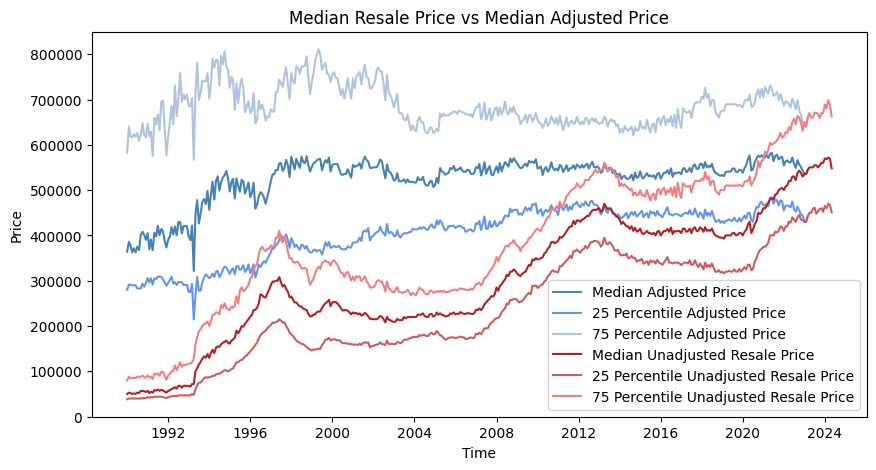

In [30]:
import matplotlib.pyplot as plt

# Plot median adjusted price vs month
# Plot median resale price vs month

# Convert month to datetime
df_1["month"] = pd.to_datetime(df_1["month"], format="%Y-%m")

# Create a set of Subplots
fig, ax = plt.subplots(figsize=(10,5))

# Plot Median and Percentile Prices
ax.plot(df_1.groupby("month")["adjusted_price"].median(), color="steelblue", label="Median Adjusted Price")
ax.plot(df_1.groupby("month")["adjusted_price"].quantile(0.25), color="cornflowerblue", label="25 Percentile Adjusted Price")
ax.plot(df_1.groupby("month")["adjusted_price"].quantile(0.75), color="lightsteelblue", label="75 Percentile Adjusted Price")
ax.plot(df_1.groupby("month")["resale_price"].median(), color="firebrick", label="Median Unadjusted Resale Price")
ax.plot(df_1.groupby("month")["resale_price"].quantile(0.25), color="indianred", label="25 Percentile Unadjusted Resale Price")
ax.plot(df_1.groupby("month")["resale_price"].quantile(0.75), color="lightcoral", label="75 Percentile Unadjusted Resale Price")

# Setting Labels and Title
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.set_title("Median Resale Price vs Median Adjusted Price")
ax.legend()

# Display the Plot
plt.show()

Generates a line plot showing the median and percentile prices of adjusted and unadjusted resale prices over time, providing a visual comparison of the two price series.

In [31]:
# Drop index, resale_price and month columns since it's not useful anymore.
df_1.drop(columns=["index", "resale_price", "month"], inplace=True)

In [32]:
# Add Region Data

# Define region categories
# Central = ['BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'TOA PAYOH']
# East = ['BEDOK','PASIR RIS', 'TAMPINES']
# West = ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST']
# North East = ['ANG MO KIO','HOUGANG', 'PUNGGOL', 'SENGKANG','SERANGOON']
# North = ['SEMBAWANG', 'WOODLANDS', 'YISHUN',]

# Defining the get_region function
def get_region(row):
	town = row["town"]
	if town in ['BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'TOA PAYOH']:
		return "CENTRAL"
	elif town in ['BEDOK','PASIR RIS', 'TAMPINES']:
		return "EAST"
	elif town in ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST']:
		return "WEST"
	elif town in ['ANG MO KIO','HOUGANG', 'PUNGGOL', 'SENGKANG','SERANGOON']:
		return "NORTH-EAST"
	elif town in ['SEMBAWANG', 'WOODLANDS', 'YISHUN']:
		return "NORTH"

# Apply the get_region function to create the "region" column
df_1["region"] = df_1.apply(get_region, axis=1)

Categorizes towns into different regions based on predefined lists and adds a new column "region" to the DataFrame df_1, indicating the region each town belongs to.

In [33]:
# Add coordinate data from block_street_name_coords.json

# Combine block and street name
df_1["block_street_name"] = df_1["block"].astype(str) + " " + df_1["street_name"].astype(str)

# Drop original block and street name columns
df_1 = df_1.drop(columns=['block', 'street_name'])

# Loads block and street name coordinates data
block_street_name_coords = pd.read_json("block_street_name_coords.json")
block_street_name_coords = block_street_name_coords.transpose()

# Join the DataFrames
df_1 = df_1.join(block_street_name_coords, on="block_street_name", how="left", rsuffix="_coords")

# Drop block_street_name column
df_1.drop(columns=["block_street_name"], inplace=True)

Combines block and street name information into a single column, loads block and street name coordinates data from a JSON file, joins this data with the original DataFrame df_1 based on the combined column and drop the block_street_name column.

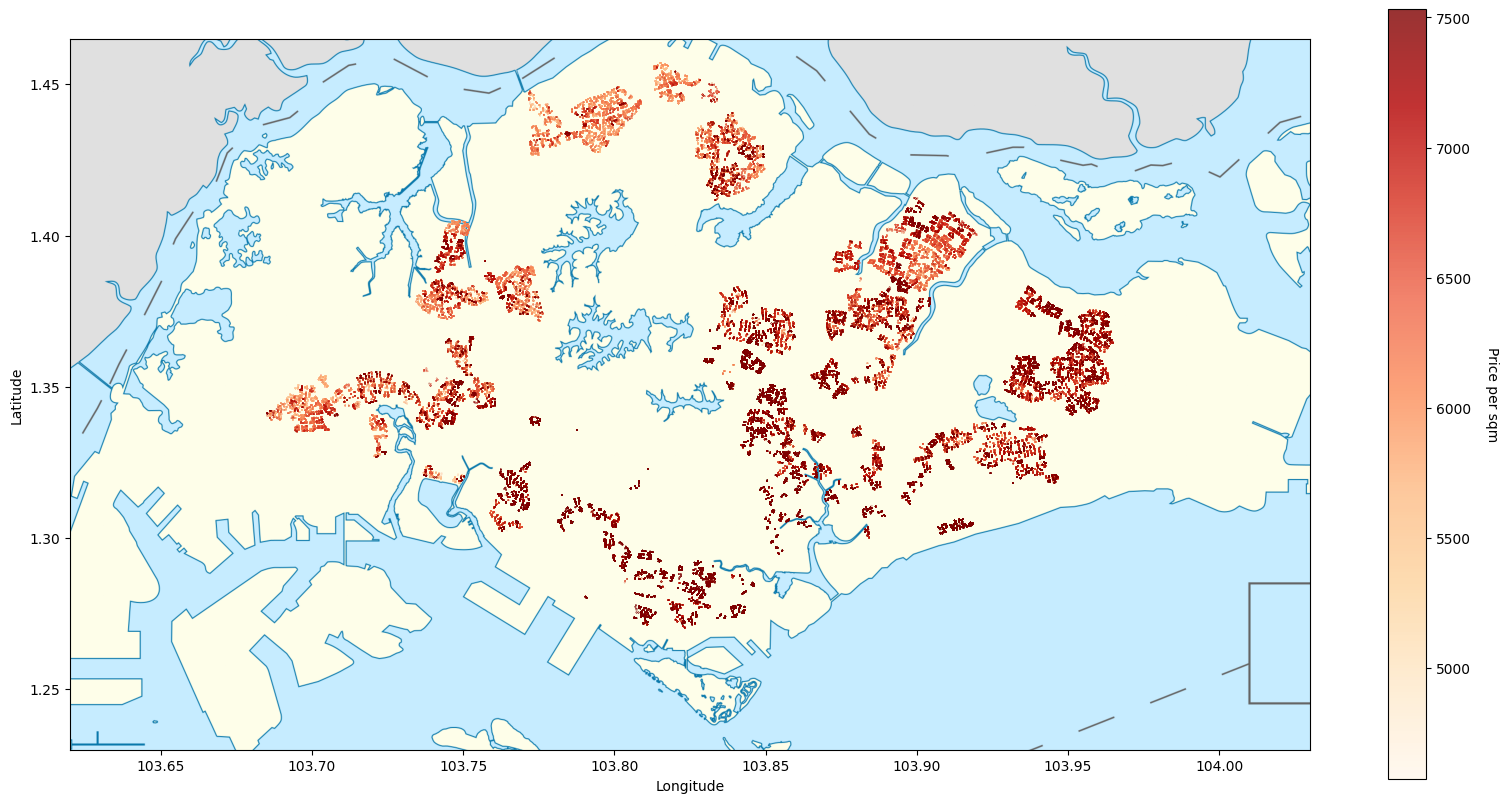

In [34]:
# Visualise data on Singapore map

import matplotlib.colors as colors

# Define the visualise function
def visualise(df, vmin, vmax):

    # Sort the DataFrame by price per sqm
    df_1_sorted = df_1.sort_values(by='price_per_sqm')

    # Extracting the data
    x = df_1_sorted['longitude']
    y = df_1_sorted['latitude']
    c = df_1_sorted['price_per_sqm']

    # Setting figure size and DPI
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['figure.dpi'] = 100

    # Display the Singapore map
    img = plt.imread('3247px-Singapore_location_map_(main_island).svg.png')
    plt.imshow(img, extent=[103.557, 104.131, 1.129, 1.493])

    # Set axes limits
    plt.xlim(103.62, 104.03)
    plt.ylim(1.23, 1.465)

    # Set axes titles
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Plot the scatter points
    plt.scatter(x, y, s=0.01, c=c, cmap='OrRd',
                norm=colors.Normalize(vmin=vmin,vmax=vmax), alpha=0.8)

    # Add colorbar
    cbar = plt.colorbar()
    cbar.set_label('Price per sqm', rotation=270, labelpad=20)

    # Setting aspect ratio and display the plot
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()

# Price per square meter calculation
df_2 = df_1
df_2["price_per_sqm"] = df_2["adjusted_price"] / df_2["floor_area_sqm"]

# Call the visualise function
visualise(df_2, df_2["price_per_sqm"].quantile(0.10), df_2["price_per_sqm"].quantile(0.90))

In [35]:
# Add distance from Downtown Core planning area (CBD)

import math as math

# Downtown Core planning area (CBD) = 1.286667, 103.853611
# Defining the Downtown Core coordinates
dg_mrt_lat = np.radians(1.286667)
dg_mrt_long = np.radians(103.853611)

# Calculate distance from CBD
df_1['distance_from_cbd'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin((np.radians(df_1['latitude']) - dg_mrt_lat)/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(np.radians(df_1['latitude'])) * np.sin((np.radians(df_1['longitude']) - dg_mrt_long)/2)**2))

Calculates the distance from each location in the DataFrame df_1 to the Downtown Core planning area (CBD) using the Haversine formula and adds this information as a new column in the DataFrame.

In [36]:
# Transform storey_range to median of range (e.g. 01 TO 03 = 2)

# Define the convert_to_median function
def convert_to_median(row):
	storey_range = row["storey_range"].split(" TO ")
	median = (int(storey_range[0]) + int(storey_range[1])) / 2
	return median

# Apply the convert_to_median function
df_1["median_storey"] = df_1.apply(convert_to_median, axis=1)

# Drop the original storey range column
df_1 = df_1.drop(columns=['storey_range'])

Transforms the storey range values in the DataFrame df_1 to their respective medians and stores the results in a new column named median_storey, while also drop the original storey_range column.

### 1.4.2 Encoding

In [37]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Transform flat_type to ordinal encoding, town and flat_model to one-hot encoding

# Select columns to transform
cols = ["town", "region", "longitude", "latitude","distance_from_cbd",
         "flat_type", "flat_model", "floor_area_sqm", "median_storey", "remaining_lease",
         "adjusted_price"]
df_1 = df_1[cols]

# Define column transformer pipeline
pipeline = ColumnTransformer([
# Add normalisation for numerical columns
     ("s", StandardScaler(), ["longitude", "latitude", "distance_from_cbd", "floor_area_sqm", "median_storey", "remaining_lease"]),
     ("o", OrdinalEncoder(), ["flat_type"]),
     ("n", OneHotEncoder(sparse_output=False), ["town", "flat_model", "region"]),
     ],
     remainder='passthrough', verbose_feature_names_out=False
)

# Apply column transformer pipeline
pipeline.set_output(transform="pandas")
df_1 = pipeline.fit_transform(df_1)

Transforms the categorical variables "flat_type", "town", "flat_model" and "region" into numerical representations using ordinal and one-hot encoding techniques. It also selects specific numerical columns to be included in the final dataset.

In [38]:
# Check whether there are missing values after performing data transformation.
pd.set_option('display.max_rows', None)
df_1.isnull().sum()

longitude                            15700
latitude                             15700
distance_from_cbd                    15700
floor_area_sqm                           0
median_storey                            0
remaining_lease                          0
flat_type                                0
town_ANG MO KIO                          0
town_BEDOK                               0
town_BISHAN                              0
town_BUKIT BATOK                         0
town_BUKIT MERAH                         0
town_BUKIT PANJANG                       0
town_BUKIT TIMAH                         0
town_CENTRAL AREA                        0
town_CHOA CHU KANG                       0
town_CLEMENTI                            0
town_GEYLANG                             0
town_HOUGANG                             0
town_JURONG EAST                         0
town_JURONG WEST                         0
town_KALLANG/WHAMPOA                     0
town_MARINE PARADE                       0
town_PASIR 

In [39]:
# Drop all missing values since we have enough samples.
df_1 = df_1.dropna()

In [40]:
# Get the latest looks of the dataframe.
pd.set_option('display.max_columns', None)
df_1.head()

longitude  latitude  distance_from_cbd  floor_area_sqm  median_storey  \
0   0.028645 -0.008268          -0.057504       -2.002571       0.687410   
1   0.002610  0.202858          -0.038191       -1.111596      -1.180637   
2  -0.001656  0.433540          -0.019008       -1.111596      -1.180637   
3   0.034081  0.090856          -0.049345       -1.072858      -0.557955   
4  -0.002043  0.441394          -0.018311       -1.111596      -1.180637   

   remaining_lease  flat_type  town_ANG MO KIO  town_BEDOK  town_BISHAN  \
0        -1.882909        1.0              1.0         0.0          0.0   
1        -1.976442        2.0              1.0         0.0          0.0   
2        -1.789376        2.0              1.0         0.0          0.0   
3        -1.789376        2.0              1.0         0.0          0.0   
4        -1.789376        2.0              1.0         0.0          0.0   

   town_BUKIT BATOK  town_BUKIT MERAH  town_BUKIT PANJANG  town_BUKIT TIMAH  \
0               0.0               0.0                 0.0               0.0   
1               0.0               0.0                 0.0               0.0   
2               0.0               0.0                 0.0               0.0   
3               0.0               0.0                 0.0               0.0   
4               0.0               0.0                 0.0               0.0   

   town_CENTRAL AREA  town_CHOA CHU KANG  town_CLEMENTI  town_GEYLANG  \
0                0.0                 0.0            0.0           0.0   
1                0.0                 0.0            0.0           0.0   
2                0.0                 0.0            0.0           0.0   
3                0.0                 0.0            0.0           0.0   
4                0.0                 0.0            0.0           0.0   

   town_HOUGANG  town_JURONG EAST  town_JURONG WEST  town_KALLANG/WHAMPOA  \
0           0.0               0.0               0.0                   0.0   
1           0.0               0.0               0.0                   0.0   
2           0.0               0.0               0.0                   0.0   
3           0.0               0.0               0.0                   0.0   
4           0.0               0.0               0.0                   0.0   

   town_MARINE PARADE  town_PASIR RIS  town_PUNGGOL  town_QUEENSTOWN  \
0                 0.0             0.0           0.0              0.0   
1                 0.0             0.0           0.0              0.0   
2                 0.0             0.0           0.0              0.0   
3                 0.0             0.0           0.0              0.0   
4                 0.0             0.0           0.0              0.0   

   town_SEMBAWANG  town_SENGKANG  town_SERANGOON  town_TAMPINES  \
0             0.0            0.0             0.0            0.0   
1             0.0            0.0             0.0            0.0   
2             0.0            0.0             0.0            0.0   
3             0.0            0.0             0.0            0.0   
4             0.0            0.0             0.0            0.0   

   town_TOA PAYOH  town_WOODLANDS  town_YISHUN  flat_model_2 ROOM  \
0             0.0             0.0          0.0                0.0   
1             0.0             0.0          0.0                0.0   
2             0.0             0.0          0.0                0.0   
3             0.0             0.0          0.0                0.0   
4             0.0             0.0          0.0                0.0   

   flat_model_3 GEN  flat_model_ADJOINED FLAT  flat_model_APARTMENT  \
0               0.0                       0.0                   0.0   
1               0.0                       0.0                   0.0   
2               0.0                       0.0                   0.0   
3               0.0                       0.0                   0.0   
4               0.0                       0.0                   0.0   

   flat_model_DBSS  flat_model_IMPROVED 

In [41]:
# Change selected columns's data type into more appropriate data types after data transformation.

# Define columns to exclude (columns that want to remain in float64)
exclude_columns = ['flat_type', 'longitude','latitude','distance_from_cbd','floor_area_sqm','median_storey','remaining_lease','adjusted_price']

# Select float64 columns
float_columns = df_1.select_dtypes(include=['float64']).drop(columns=exclude_columns).columns

# Loop through each float column and convert its data type to uint8
for col in float_columns:
    df_1[col] = df_1[col].astype('uint8')

Selectively converts float columns in the DataFrame df_1 to uint8 data type, excluding columns specified in exclude_columns. This conversion reduces memory usage by representing numerical values more efficiently because they fall within the range supported by uint8.

In [42]:
# Get the latest overall information about data columns that we have.
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882024 entries, 0 to 924718
Data columns (total 60 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   longitude                          882024 non-null  float64
 1   latitude                           882024 non-null  float64
 2   distance_from_cbd                  882024 non-null  float64
 3   floor_area_sqm                     882024 non-null  float64
 4   median_storey                      882024 non-null  float64
 5   remaining_lease                    882024 non-null  float64
 6   flat_type                          882024 non-null  float64
 7   town_ANG MO KIO                    882024 non-null  uint8  
 8   town_BEDOK                         882024 non-null  uint8  
 9   town_BISHAN                        882024 non-null  uint8  
 10  town_BUKIT BATOK                   882024 non-null  uint8  
 11  town_BUKIT MERAH                   882024 no

In [43]:
# Provides valuable insights into the distribution and basic statistics of the data after performing data transformation.
df_1.describe()

longitude       latitude  distance_from_cbd  floor_area_sqm  \
count  882024.000000  882024.000000      882024.000000   882024.000000   
mean       -0.000175      -0.005100          -0.000086        0.020073   
std         1.014845       0.998697           1.014965        0.995661   
min      -169.964924     -32.179751          -0.188541       -2.506165   
25%        -0.102979      -0.661743          -0.053448       -0.879168   
50%         0.012116      -0.166946           0.002280       -0.104407   
75%         0.102235       0.475295           0.049564        0.709092   
max         0.210394       2.237272         170.753981        5.938726   

       median_storey  remaining_lease      flat_type  town_ANG MO KIO  \
count  882024.000000    882024.000000  882024.000000    882024.000000   
mean       -0.005108         0.027900       3.029986         0.056591   
std         0.993655         0.980099       0.944158         0.231060   
min        -1.180637        -3.660039       0.000000         0.000000   
25%        -0.557955        -0.573445       2.000000         0.000000   
50%         0.064728         0.174820       3.000000         0.000000   
75%         0.687410         0.829552       4.000000         0.000000   
max         8.782281         1.858416       6.000000         1.000000   

          town_BEDOK    town_BISHAN  town_BUKIT BATOK  town_BUKIT MERAH  \
count  882024.000000  882024.000000     882024.000000     882024.000000   
mean        0.073278       0.023616          0.047745          0.034543   
std         0.260593       0.151850          0.213226          0.182620   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          0.000000          0.000000   
50%         0.000000       0.000000          0.000000          0.000000   
75%         0.000000       0.000000          0.000000          0.000000   
max         1.000000       1.000000          1.000000          1.000000   

       town_BUKIT PANJANG  town_BUKIT TIMAH  town_CENTRAL AREA  \
count       882024.000000     882024.000000      882024.000000   
mean             0.030353          0.002781           0.007287   
std              0.171557          0.052663           0.085050   
min              0.000000          0.000000           0.000000   
25%              0.000000          0.000000           0.000000   
50%              0.000000          0.000000           0.000000   
75%              0.000000          0.000000           0.000000   
max              1.000000          1.000000           1.000000   

       town_CHOA CHU KANG  town_CLEMENTI  town_GEYLANG   town_HOUGANG  \
count       882024.000000  882024.000000  882024.00000  882024.000000   
mean             0.041884       0.029085       0.03027       0.055551   
std              0.200325       0.168046       0.17133       0.229052   
min              0.000000       0.000000       0.00000       0.000000   
25%              0.000000       0.000000       0.00000       0.000000   
50%              0.000000       0.000000       0.00000       0.000000   
75%              0.000000       0.000000       0.00000       0.000000   
max              1.000000       1.000000       1.00000       1.000000   

       town_JURONG EAST  town_JURONG WEST  town_KALLANG/WHAMPOA  \
count     882024.000000     882024.000000         882024.000000   
mean           0.026826          0.070762              0.029376   
std            0.161574          0.256427              0.168857   
min            0.000000          0.000000              0.000000   
25%            0.000000          0.000000              0.000000   
50%            0.000000          0.000000              0.000000   
75%            0.000000          0.000000              0.000000   
max            1.000000          1.000000              1.000000   

       town_MARINE PARADE  town_PASIR RIS   town_PUNGGOL  town_QUEENSTOWN  \
count       882024.000000   882024.000000  882024.000000    882024.000000   

### 1.4.3 Feature Scaling

#### 1.4.3.1 Min-max normalization

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'distance_from_cbd'}>],
       [<Axes: title={'center': 'floor_area_sqm'}>,
        <Axes: title={'center': 'median_storey'}>,
        <Axes: title={'center': 'remaining_lease'}>],
       [<Axes: title={'center': 'flat_type'}>,
        <Axes: title={'center': 'adjusted_price'}>, <Axes: >]],
      dtype=object)

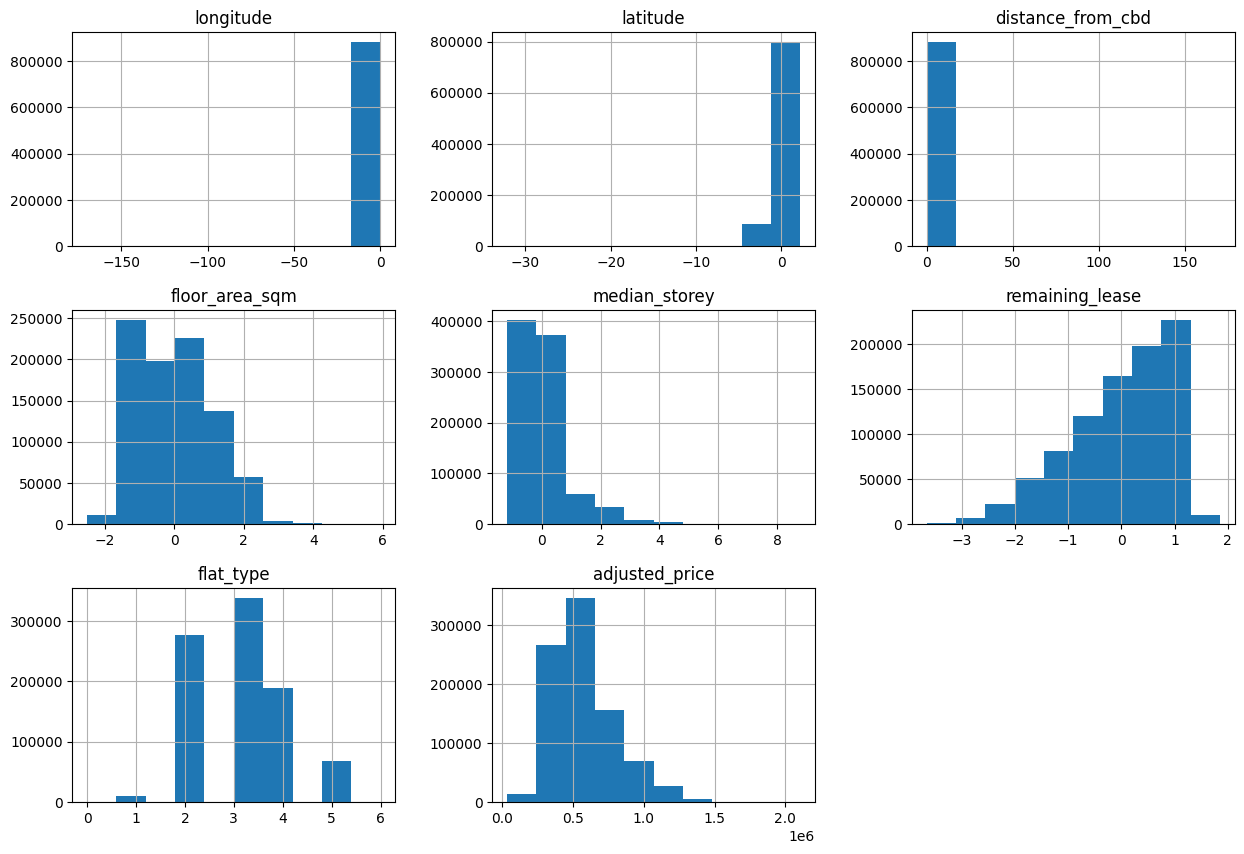

In [44]:
# Before min-max normalization
# Display histograms for each float64 data type features in the DataFrame 'df_1'

# Filter columns with float64 data type
float_columns = df_1.select_dtypes(include=['float64'])

# figsize=(15, 10) sets the size of the resulting figure to 15 inches in width and 10 inches in height.
float_columns.hist(figsize=(15, 10))

* The purpose of creating histograms before normalization is to understand the distribution of values in each float64 data type features.

* Histograms provide insights into the spread and concentration of values, potential outliers and the general shape of the data distribution.

In [45]:
from sklearn import preprocessing

# Create a MinMaxScaler with a specified feature range of (0, 1)
m = preprocessing.MinMaxScaler(feature_range=(0,1))

# Create a copy of the original DataFrame 'df' for normalization
df_norm_min_max = df_1.copy()

# Apply min-max normalization to selected columns
for column in float_columns.columns:
    df_norm_min_max[column] = m.fit_transform(df_1[[column]])

# Display the first few rows of the DataFrame after min-max normalization
df_norm_min_max.head()

longitude  latitude  distance_from_cbd  floor_area_sqm  median_storey  \
0   0.998932  0.934755           0.000767        0.059633         0.1875   
1   0.998779  0.940889           0.000880        0.165138         0.0000   
2   0.998754  0.947592           0.000992        0.165138         0.0000   
3   0.998964  0.937635           0.000814        0.169725         0.0625   
4   0.998752  0.947820           0.000996        0.165138         0.0000   

   remaining_lease  flat_type  town_ANG MO KIO  town_BEDOK  town_BISHAN  \
0         0.322034   0.166667                1           0            0   
1         0.305085   0.333333                1           0            0   
2         0.338983   0.333333                1           0            0   
3         0.338983   0.333333                1           0            0   
4         0.338983   0.333333                1           0            0   

   town_BUKIT BATOK  town_BUKIT MERAH  town_BUKIT PANJANG  town_BUKIT TIMAH  \
0                 0                 0                   0                 0   
1                 0                 0                   0                 0   
2                 0                 0                   0                 0   
3                 0                 0                   0                 0   
4                 0                 0                   0                 0   

   town_CENTRAL AREA  town_CHOA CHU KANG  town_CLEMENTI  town_GEYLANG  \
0                  0                   0              0             0   
1                  0                   0              0             0   
2                  0                   0              0             0   
3                  0                   0              0             0   
4                  0                   0              0             0   

   town_HOUGANG  town_JURONG EAST  town_JURONG WEST  town_KALLANG/WHAMPOA  \
0             0                 0                 0                     0   
1             0                 0                 0                     0   
2             0                 0                 0                     0   
3             0                 0                 0                     0   
4             0                 0                 0                     0   

   town_MARINE PARADE  town_PASIR RIS  town_PUNGGOL  town_QUEENSTOWN  \
0                   0               0             0                0   
1                   0               0             0                0   
2                   0               0             0                0   
3                   0               0             0                0   
4                   0               0             0                0   

   town_SEMBAWANG  town_SENGKANG  town_SERANGOON  town_TAMPINES  \
0               0              0               0              0   
1               0              0               0              0   
2               0              0               0              0   
3               0              0               0              0   
4               0              0               0              0   

   town_TOA PAYOH  town_WOODLANDS  town_YISHUN  flat_model_2 ROOM  \
0               0               0            0                  0   
1               0               0            0                  0   
2               0               0            0                  0   
3               0               0            0                  0   
4               0               0            0                  0   

   flat_model_3 GEN  flat_model_ADJOINED FLAT  flat_model_APARTMENT  \
0                 0                         0                     0   
1                 0                         0                     0   
2                 0                         0                     0   
3                 0                         0                     0   
4                 0                         0                     0   

   flat_model_DBSS  flat_model_IMPROVED 

* After this operation, the selected float features in df_norm_min_max will have values scaled to the range [0, 1].

* This min-max normalization will be used for machine learning algorithms that are sensitive to the scale of input features and require features to be scaled to a specific range such as Neural Networks, Support Vector Machines (SVM) and K-Nearest Neighbors (KNN).

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'distance_from_cbd'}>],
       [<Axes: title={'center': 'floor_area_sqm'}>,
        <Axes: title={'center': 'median_storey'}>,
        <Axes: title={'center': 'remaining_lease'}>],
       [<Axes: title={'center': 'flat_type'}>,
        <Axes: title={'center': 'adjusted_price'}>, <Axes: >]],
      dtype=object)

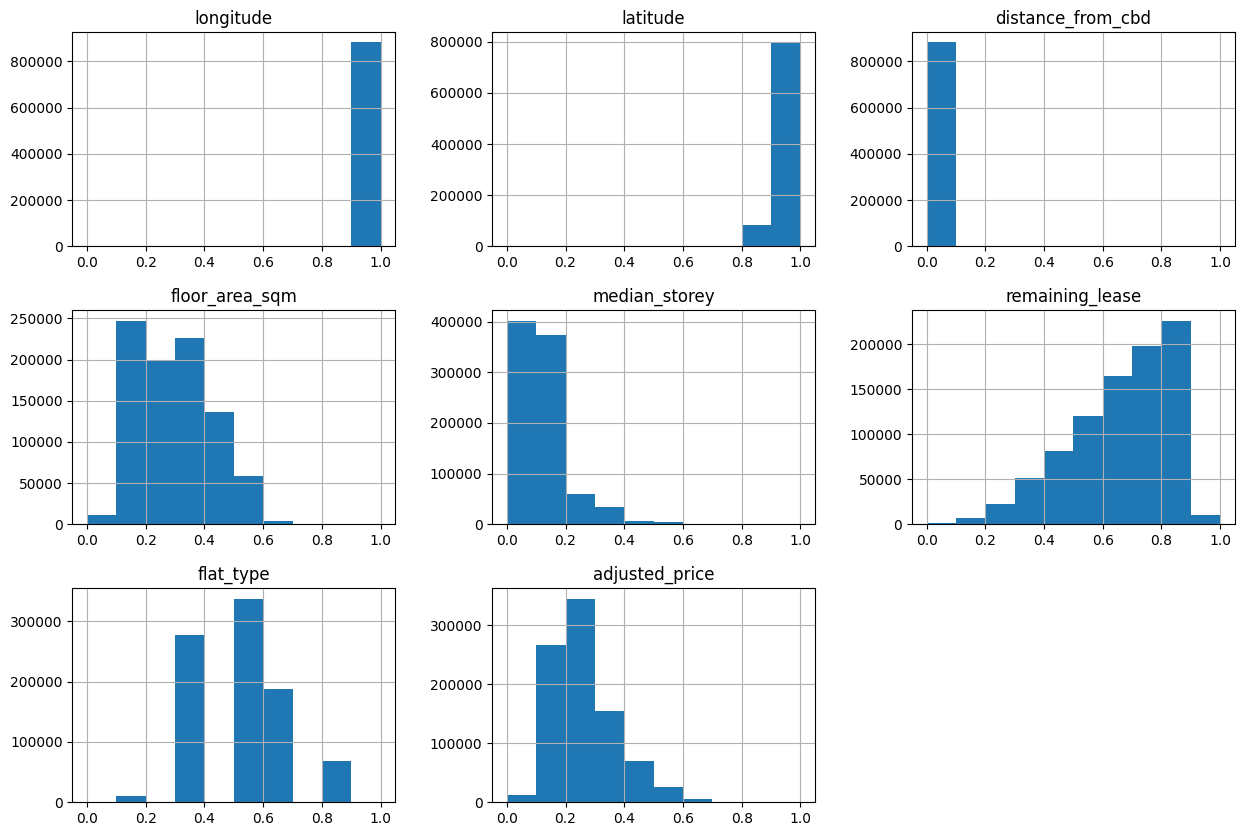

In [46]:
# After min-max normalization
# Display histograms for each float data type features in the DataFrame 'df_norm_min_max'

# Filter columns with float64 data type
float_columns_norm = df_norm_min_max.select_dtypes(include=['float64'])

# figsize=(15, 10) sets the size of the resulting figure to 15 inches in width and 10 inches in height.
float_columns_norm.hist(figsize=(15,10))

* The purpose of displaying histograms after min-max normalization is to observe the distribution of values in each float data type features and to check whether the normalization has effectively scaled the values within the desired range.

* This visualization helps in assessing the impact of normalization on the dataset and identifying any potential issues or improvements needed in the preprocessing steps.

#### 1.4.3.2 Z-score normalization

In [47]:
# Create a StandardScaler
z = preprocessing.StandardScaler()

# Create a copy of the original DataFrame 'df_1' for normalization
df_norm_std_scaler = df_1.copy()

# Apply standardization to selected columns
for column in float_columns.columns:
    df_norm_std_scaler[column] = z.fit_transform(df_1[[column]])

# Display the first few rows of the DataFrame after z-score normalization / standardization
df_norm_std_scaler.head()

longitude  latitude  distance_from_cbd  floor_area_sqm  median_storey  \
0   0.028398 -0.003173          -0.056571       -2.031459       0.696941   
1   0.002745  0.208229          -0.037543       -1.136601      -1.183037   
2  -0.001459  0.439212          -0.018643       -1.136601      -1.183037   
3   0.033755  0.096081          -0.048532       -1.097694      -0.556378   
4  -0.001841  0.447077          -0.017956       -1.136601      -1.183037   

   remaining_lease  flat_type  town_ANG MO KIO  town_BEDOK  town_BISHAN  \
0        -1.949609  -2.150051                1           0            0   
1        -2.045042  -1.090905                1           0            0   
2        -1.854177  -1.090905                1           0            0   
3        -1.854177  -1.090905                1           0            0   
4        -1.854177  -1.090905                1           0            0   

   town_BUKIT BATOK  town_BUKIT MERAH  town_BUKIT PANJANG  town_BUKIT TIMAH  \
0                 0                 0                   0                 0   
1                 0                 0                   0                 0   
2                 0                 0                   0                 0   
3                 0                 0                   0                 0   
4                 0                 0                   0                 0   

   town_CENTRAL AREA  town_CHOA CHU KANG  town_CLEMENTI  town_GEYLANG  \
0                  0                   0              0             0   
1                  0                   0              0             0   
2                  0                   0              0             0   
3                  0                   0              0             0   
4                  0                   0              0             0   

   town_HOUGANG  town_JURONG EAST  town_JURONG WEST  town_KALLANG/WHAMPOA  \
0             0                 0                 0                     0   
1             0                 0                 0                     0   
2             0                 0                 0                     0   
3             0                 0                 0                     0   
4             0                 0                 0                     0   

   town_MARINE PARADE  town_PASIR RIS  town_PUNGGOL  town_QUEENSTOWN  \
0                   0               0             0                0   
1                   0               0             0                0   
2                   0               0             0                0   
3                   0               0             0                0   
4                   0               0             0                0   

   town_SEMBAWANG  town_SENGKANG  town_SERANGOON  town_TAMPINES  \
0               0              0               0              0   
1               0              0               0              0   
2               0              0               0              0   
3               0              0               0              0   
4               0              0               0              0   

   town_TOA PAYOH  town_WOODLANDS  town_YISHUN  flat_model_2 ROOM  \
0               0               0            0                  0   
1               0               0            0                  0   
2               0               0            0                  0   
3               0               0            0                  0   
4               0               0            0                  0   

   flat_model_3 GEN  flat_model_ADJOINED FLAT  flat_model_APARTMENT  \
0                 0                         0                     0   
1                 0                         0                     0   
2                 0                         0                     0   
3                 0                         0                     0   
4                 0                         0                     0   

   flat_model_DBSS  flat_model_IMPROVED 

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'distance_from_cbd'}>],
       [<Axes: title={'center': 'floor_area_sqm'}>,
        <Axes: title={'center': 'median_storey'}>,
        <Axes: title={'center': 'remaining_lease'}>],
       [<Axes: title={'center': 'flat_type'}>,
        <Axes: title={'center': 'adjusted_price'}>, <Axes: >]],
      dtype=object)

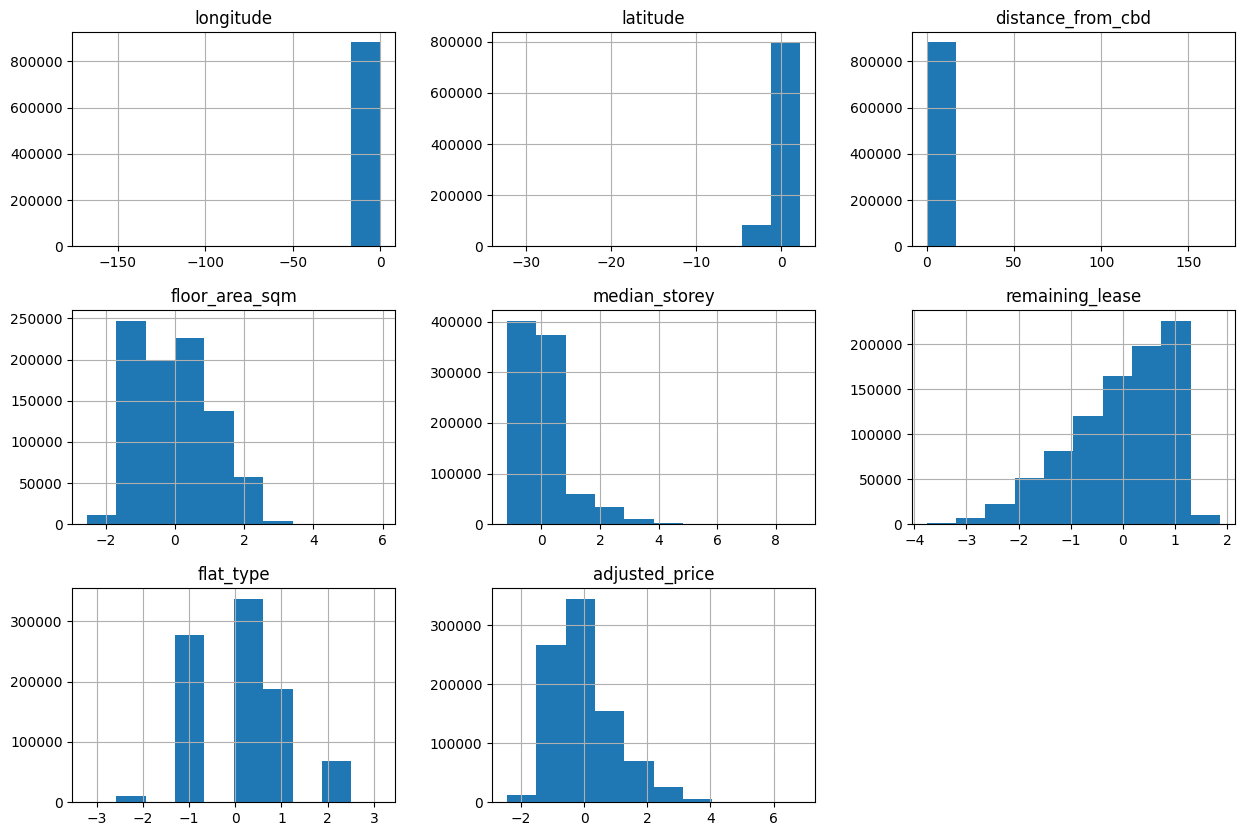

In [48]:
# After z-score normalization
# Display histograms for each float data type features in the DataFrame 'df_norm_std_scaler'

# Filter columns with float64 data type
float_columns_stand = df_norm_std_scaler.select_dtypes(include=['float64'])

# Display histograms for each numerical feature in the DataFrame after standardization
float_columns_stand.hist(figsize=(15,10))

* After this operation, the selected numerical features in df_norm_std_scaler will have a mean of 0 and a standard deviation of 1, which is a common requirement for machine learning algorithms that require standardized inputs or assume Gaussian distributions such as
Linear Regression, Logistic Regression and Principal Component Analysis (PCA).
* The histograms help visualize the impact of standardization on the distribution of values in each feature.

### 1.4.4 Correlation Analysis

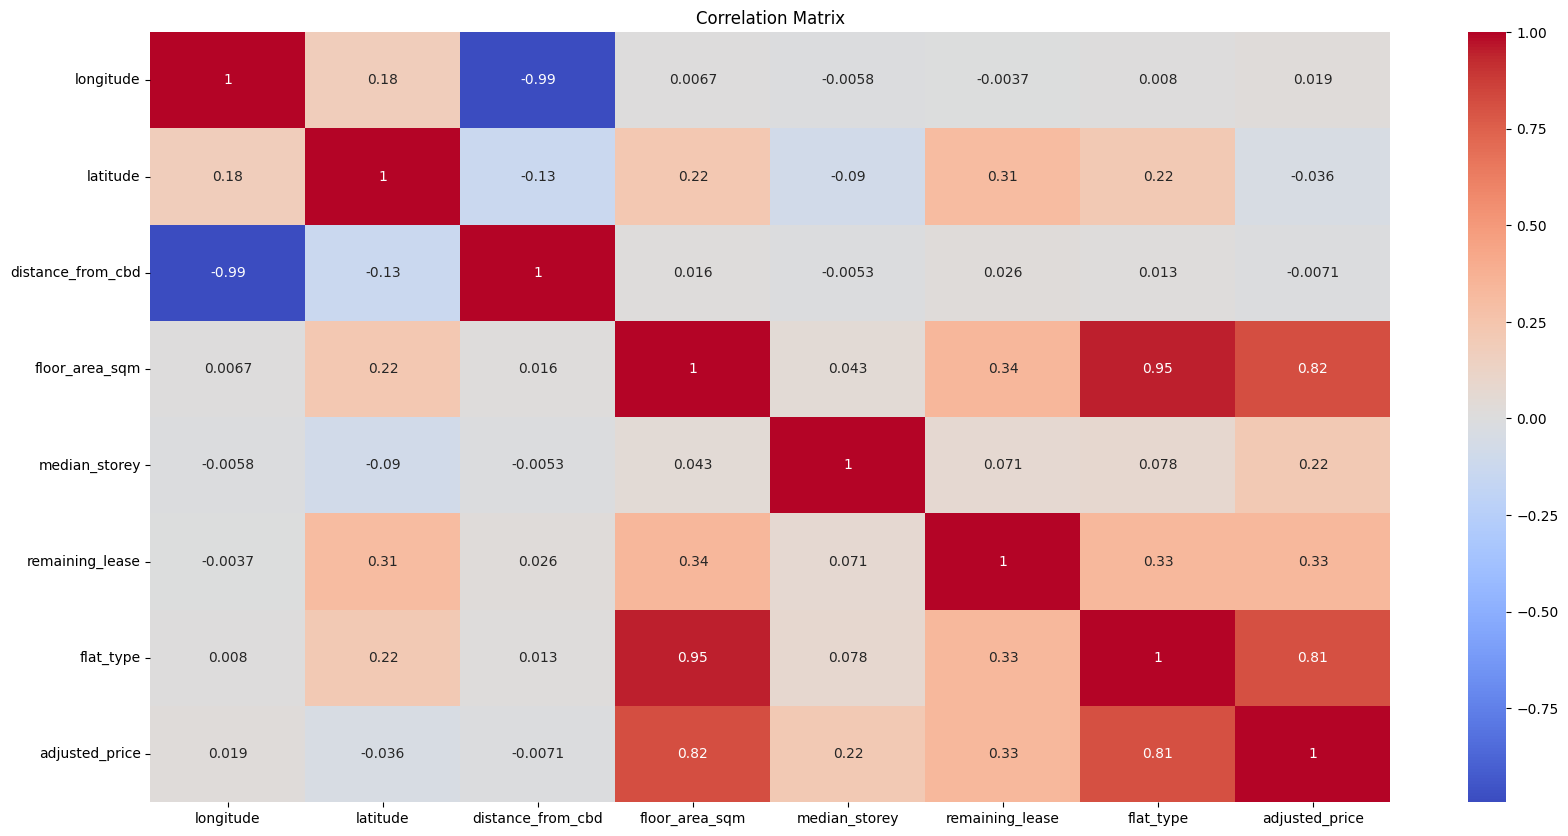

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df_1.copy()
numerical_columns = df_corr.select_dtypes(include=['float']).columns
df_corr_numerical = df_corr[numerical_columns]
corr = df_corr_numerical.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

In [50]:
# Find correlation coefficients between every pair of numerical columns in df_1 after data transformation.
Corr = df_1.corr()
Corr

longitude  latitude  distance_from_cbd  \
longitude                           1.000000  0.180522          -0.993281   
latitude                            0.180522  1.000000          -0.133446   
distance_from_cbd                  -0.993281 -0.133446           1.000000   
floor_area_sqm                      0.006685  0.224460           0.015932   
median_storey                      -0.005843 -0.089604          -0.005270   
remaining_lease                    -0.003733  0.314386           0.026070   
flat_type                           0.007967  0.218251           0.013494   
town_ANG MO KIO                     0.004384  0.051019          -0.009521   
town_BEDOK                          0.041537 -0.216583          -0.013803   
town_BISHAN                         0.002476 -0.034611          -0.011346   
town_BUKIT BATOK                   -0.031088 -0.048546           0.003564   
town_BUKIT MERAH                   -0.004534 -0.364062          -0.026886   
town_BUKIT PANJANG                 -0.019326  0.079965           0.005338   
town_BUKIT TIMAH                   -0.004271 -0.038794          -0.003037   
town_CENTRAL AREA                   0.001599 -0.141004          -0.014579   
town_CHOA CHU KANG                 -0.030402  0.120447           0.013143   
town_CLEMENTI                      -0.019703 -0.201021          -0.007289   
town_GEYLANG                       -0.018678 -0.173724           0.015847   
town_HOUGANG                        0.020525  0.041451          -0.007642   
town_JURONG EAST                   -0.026005 -0.095227           0.002881   
town_JURONG WEST                   -0.056654 -0.112787           0.018975   
town_KALLANG/WHAMPOA                0.006913 -0.177499          -0.023060   
town_MARINE PARADE                  0.011679 -0.130566          -0.008947   
town_PASIR RIS                      0.036213  0.044857           0.006242   
town_PUNGGOL                        0.016709  0.130927           0.004971   
town_QUEENSTOWN                    -0.010966 -0.245648          -0.017052   
town_SEMBAWANG                     -0.003372  0.251023           0.013907   
town_SENGKANG                       0.017488  0.124820           0.001679   
town_SERANGOON                      0.009248 -0.006346          -0.009025   
town_TAMPINES                       0.055774 -0.071014           0.000749   
town_TOA PAYOH                      0.005583 -0.114185          -0.019483   
town_WOODLANDS                     -0.021185  0.499256           0.029918   
town_YISHUN                         0.000218  0.445187           0.019730   
flat_model_2 ROOM                   0.000424  0.001049           0.000109   
flat_model_3 GEN                    0.000152  0.003005           0.000095   
flat_model_ADJOINED FLAT            0.000137 -0.024014          -0.002286   
flat_model_APARTMENT                0.003722  0.081128           0.006958   
flat_model_DBSS                     0.002948 -0.014459          -0.002089   
flat_model_IMPROVED                 0.006217 -0.109825          -0.012421   
flat_model_IMPROVED MAISONETTE      0.000990 -0.001482          -0.000630   
flat_model_MAISONETTE               0.001856  0.006194          -0.000115   
flat_model_MODEL A                 -0.000171  0.107817           0.009061   
flat_model_MODEL A MAISONETTE       0.000622 -0.027911          -0.002253   
flat_model_MODEL A2                -0.005881  0.097836           0.006650   
flat_model_MULTI-GENERATION         0.001471  0.015730           0.000433   
flat_model_NEW GENERATION          -0.013062 -0.083319           0.004135   
flat_model_PREMIUM APARTMENT       -0.000605  0.164925           0.010211   
flat_model_PREMIUM APARTMENT LOFT  -0.000130 -0.011542          -0.001005   
flat_model_PREMIUM MAISONETTE       0.000586  0.003395           0.000464   
flat_model_SIMPLIFIED               0.005678  0.098933           0.000817   
flat_model_STANDARD                 0.003224 -0.239674          -0.020707   
flat_model_TERRACE             

In [51]:
# Another way to shows correlation between variables.

# Disable correlation of 1 because its comparing with itself
# Without using enumerate and val1 > val2 (upper right of matrix), 32 sets of 16 pairs were printed (theres a duplicate for each)
# With val1 > val2, non duplicate sets are shown
# Iterate through column, then through index

for val1, column in enumerate(Corr):
    for val2, index in enumerate(Corr[column].index):
        if 0.2 <= Corr[column][index] < 1 and val1 > val2:
            print(str(Corr[column][index]) + ' ' + str(column) + ' and ' + str(index))

0.224460081857962 floor_area_sqm and latitude
0.31438560869490284 remaining_lease and latitude
0.34321116060721407 remaining_lease and floor_area_sqm
0.21825148169622774 flat_type and latitude
0.9530248932215057 flat_type and floor_area_sqm
0.3310987068603612 flat_type and remaining_lease
0.20666725829112748 town_PASIR RIS and floor_area_sqm
0.25102336880796006 town_SEMBAWANG and latitude
0.49925641451645275 town_WOODLANDS and latitude
0.44518728288454684 town_YISHUN and latitude
0.3961950677495595 flat_model_APARTMENT and floor_area_sqm
0.4214342701396829 flat_model_APARTMENT and flat_type
0.3735637160757421 flat_model_MAISONETTE and floor_area_sqm
0.38432778996542316 flat_model_MAISONETTE and flat_type
0.23456834484522066 flat_model_MODEL A and remaining_lease
0.3819496486937186 flat_model_NEW GENERATION and town_ANG MO KIO
0.20169849569202802 flat_model_NEW GENERATION and town_BEDOK
0.24401775558136937 flat_model_NEW GENERATION and town_CLEMENTI
0.306089865336543 flat_model_PREMIUM 

In [52]:
#Show only strong positive correlation between two variables, corr > 0.4

for val1, column in enumerate(Corr):
    for val2, index in enumerate(Corr[column].index):
        if 0.4 <= Corr[column][index] < 1 and val1 > val2:
            print(str(Corr[column][index]) + ' ' + str(column) + ' and ' + str(index))

0.9530248932215057 flat_type and floor_area_sqm
0.49925641451645275 town_WOODLANDS and latitude
0.44518728288454684 town_YISHUN and latitude
0.4214342701396829 flat_model_APARTMENT and flat_type
0.5654101063073191 region_EAST and town_BEDOK
0.6261194834931528 region_EAST and town_TAMPINES
0.7506083464531368 region_NORTH and latitude
0.6288972538927561 region_NORTH and town_WOODLANDS
0.6553103296564852 region_NORTH and town_YISHUN
0.5021982744503317 region_NORTH-EAST and town_ANG MO KIO
0.4972845815118848 region_NORTH-EAST and town_HOUGANG
0.48226848934820676 region_WEST and town_JURONG WEST
0.8189895569564768 adjusted_price and floor_area_sqm
0.8113611588028027 adjusted_price and flat_type


Analyzing the correlation helps to understand relationships between variables, identify multicollinearity (high correlations between predictors) and select features for predictive modeling or further analysis.

## 1.5 Data Aggregation

In [53]:
# Grouping variables
grouping_variables = ['flat_type']

# Aggregation functions
aggregation_functions = {
    'longitude': 'mean',
    'latitude': 'mean',
    'distance_from_cbd': 'mean',
    'floor_area_sqm': 'mean',
    'median_storey': 'mean',
    'remaining_lease': 'mean',
    'adjusted_price': 'sum'
}

# Perform data aggregation
df_aggregation = df_1.groupby(grouping_variables).agg(aggregation_functions).reset_index()
df_aggregation

flat_type  longitude  latitude  distance_from_cbd  floor_area_sqm  \
0        0.0  -0.027820 -1.983977          -0.141169       -2.506165   
1        1.0   0.011683 -0.796511          -0.080077       -1.928800   
2        2.0  -0.012918 -0.344210          -0.017628       -1.052669   
3        3.0   0.002808  0.154201           0.007265        0.034211   
4        4.0   0.007828  0.159753           0.009739        0.973540   
5        5.0   0.012928  0.260546           0.020663        1.978507   
6        6.0   0.060321  0.631397           0.017703        2.554162   

   median_storey  remaining_lease  adjusted_price  
0      -0.209415        -1.014475    1.000800e+08  
1      -0.144633        -0.767160    2.493969e+09  
2      -0.122815        -0.501100    1.047995e+11  
3      -0.015708         0.244109    1.932579e+11  
4       0.240857         0.341360    1.440228e+11  
5      -0.130288         0.370155    6.515143e+10  
6      -0.167184         0.234563    6.024430e+08

Groups the data by the 'flat_type' column and calculates the mean of float data type columns and the sum of the 'adjusted_price' column within each group.

In [54]:
# Compute additional summary statistics for the grouped/aggregated data
df_aggregation.describe()

flat_type  longitude  latitude  distance_from_cbd  floor_area_sqm  \
count   7.000000   7.000000  7.000000           7.000000        7.000000   
mean    3.000000   0.007833 -0.274115          -0.026215        0.007541   
std     2.160247   0.027455  0.883077           0.061548        1.936321   
min     0.000000  -0.027820 -1.983977          -0.141169       -2.506165   
25%     1.500000  -0.005055 -0.570360          -0.048853       -1.490734   
50%     3.000000   0.007828  0.154201           0.007265        0.034211   
75%     4.500000   0.012306  0.210150           0.013721        1.476023   
max     6.000000   0.060321  0.631397           0.020663        2.554162   

       median_storey  remaining_lease  adjusted_price  
count       7.000000         7.000000    7.000000e+00  
mean       -0.078455        -0.156078    7.291830e+10  
std         0.152728         0.586859    7.757347e+10  
min        -0.209415        -1.014475    1.000800e+08  
25%        -0.155908        -0.634130    1.548206e+09  
50%        -0.130288         0.234563    6.515143e+10  
75%        -0.069261         0.292734    1.244111e+11  
max         0.240857         0.370155    1.932579e+11

<Axes: >

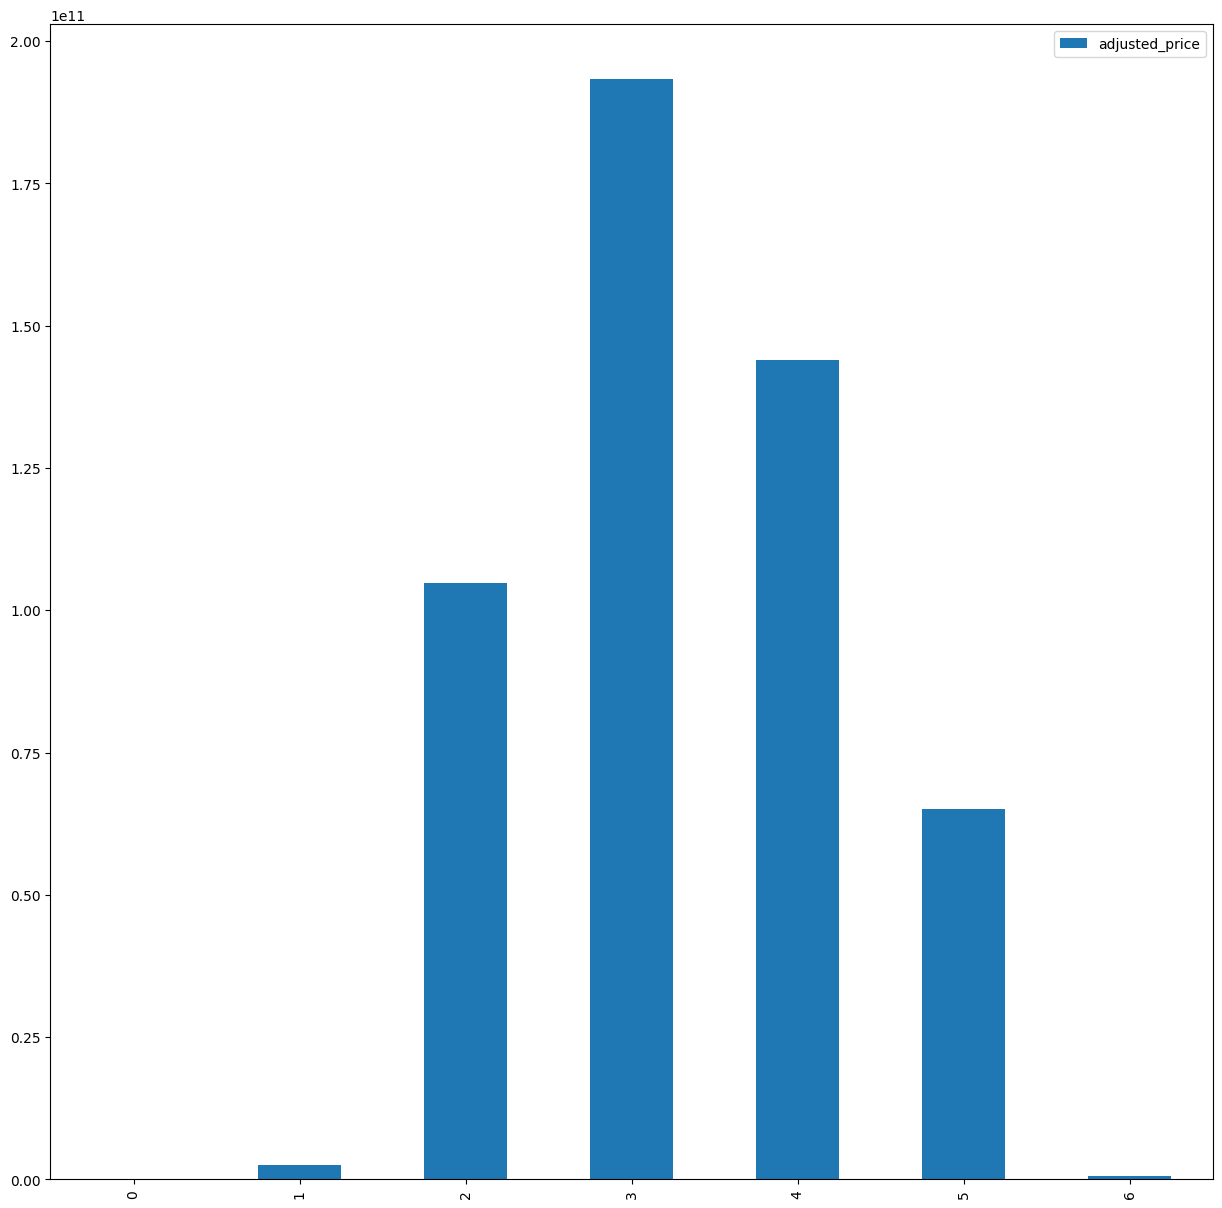

In [55]:
#Create a bar plot with 'adjusted_price' as y-axis, with width 15 inches and height 20 inches
df_aggregation.plot.bar(y='adjusted_price',figsize=(15,15),use_index=True)

* These steps helps us to explore and understand the characteristics of the data after performing groupby or aggregation operations.

## 1.6 Data Visualization

In [56]:
# Display descriptive statistics for each numerical column in the DataFrame 'df_1' before visualize the data
df_1.describe()

longitude       latitude  distance_from_cbd  floor_area_sqm  \
count  882024.000000  882024.000000      882024.000000   882024.000000   
mean       -0.000175      -0.005100          -0.000086        0.020073   
std         1.014845       0.998697           1.014965        0.995661   
min      -169.964924     -32.179751          -0.188541       -2.506165   
25%        -0.102979      -0.661743          -0.053448       -0.879168   
50%         0.012116      -0.166946           0.002280       -0.104407   
75%         0.102235       0.475295           0.049564        0.709092   
max         0.210394       2.237272         170.753981        5.938726   

       median_storey  remaining_lease      flat_type  town_ANG MO KIO  \
count  882024.000000    882024.000000  882024.000000    882024.000000   
mean       -0.005108         0.027900       3.029986         0.056591   
std         0.993655         0.980099       0.944158         0.231060   
min        -1.180637        -3.660039       0.000000         0.000000   
25%        -0.557955        -0.573445       2.000000         0.000000   
50%         0.064728         0.174820       3.000000         0.000000   
75%         0.687410         0.829552       4.000000         0.000000   
max         8.782281         1.858416       6.000000         1.000000   

          town_BEDOK    town_BISHAN  town_BUKIT BATOK  town_BUKIT MERAH  \
count  882024.000000  882024.000000     882024.000000     882024.000000   
mean        0.073278       0.023616          0.047745          0.034543   
std         0.260593       0.151850          0.213226          0.182620   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          0.000000          0.000000   
50%         0.000000       0.000000          0.000000          0.000000   
75%         0.000000       0.000000          0.000000          0.000000   
max         1.000000       1.000000          1.000000          1.000000   

       town_BUKIT PANJANG  town_BUKIT TIMAH  town_CENTRAL AREA  \
count       882024.000000     882024.000000      882024.000000   
mean             0.030353          0.002781           0.007287   
std              0.171557          0.052663           0.085050   
min              0.000000          0.000000           0.000000   
25%              0.000000          0.000000           0.000000   
50%              0.000000          0.000000           0.000000   
75%              0.000000          0.000000           0.000000   
max              1.000000          1.000000           1.000000   

       town_CHOA CHU KANG  town_CLEMENTI  town_GEYLANG   town_HOUGANG  \
count       882024.000000  882024.000000  882024.00000  882024.000000   
mean             0.041884       0.029085       0.03027       0.055551   
std              0.200325       0.168046       0.17133       0.229052   
min              0.000000       0.000000       0.00000       0.000000   
25%              0.000000       0.000000       0.00000       0.000000   
50%              0.000000       0.000000       0.00000       0.000000   
75%              0.000000       0.000000       0.00000       0.000000   
max              1.000000       1.000000       1.00000       1.000000   

       town_JURONG EAST  town_JURONG WEST  town_KALLANG/WHAMPOA  \
count     882024.000000     882024.000000         882024.000000   
mean           0.026826          0.070762              0.029376   
std            0.161574          0.256427              0.168857   
min            0.000000          0.000000              0.000000   
25%            0.000000          0.000000              0.000000   
50%            0.000000          0.000000              0.000000   
75%            0.000000          0.000000              0.000000   
max            1.000000          1.000000              1.000000   

       town_MARINE PARADE  town_PASIR RIS   town_PUNGGOL  town_QUEENSTOWN  \
count       882024.000000   882024.000000  882024.000000    882024.000000   

<Axes: >

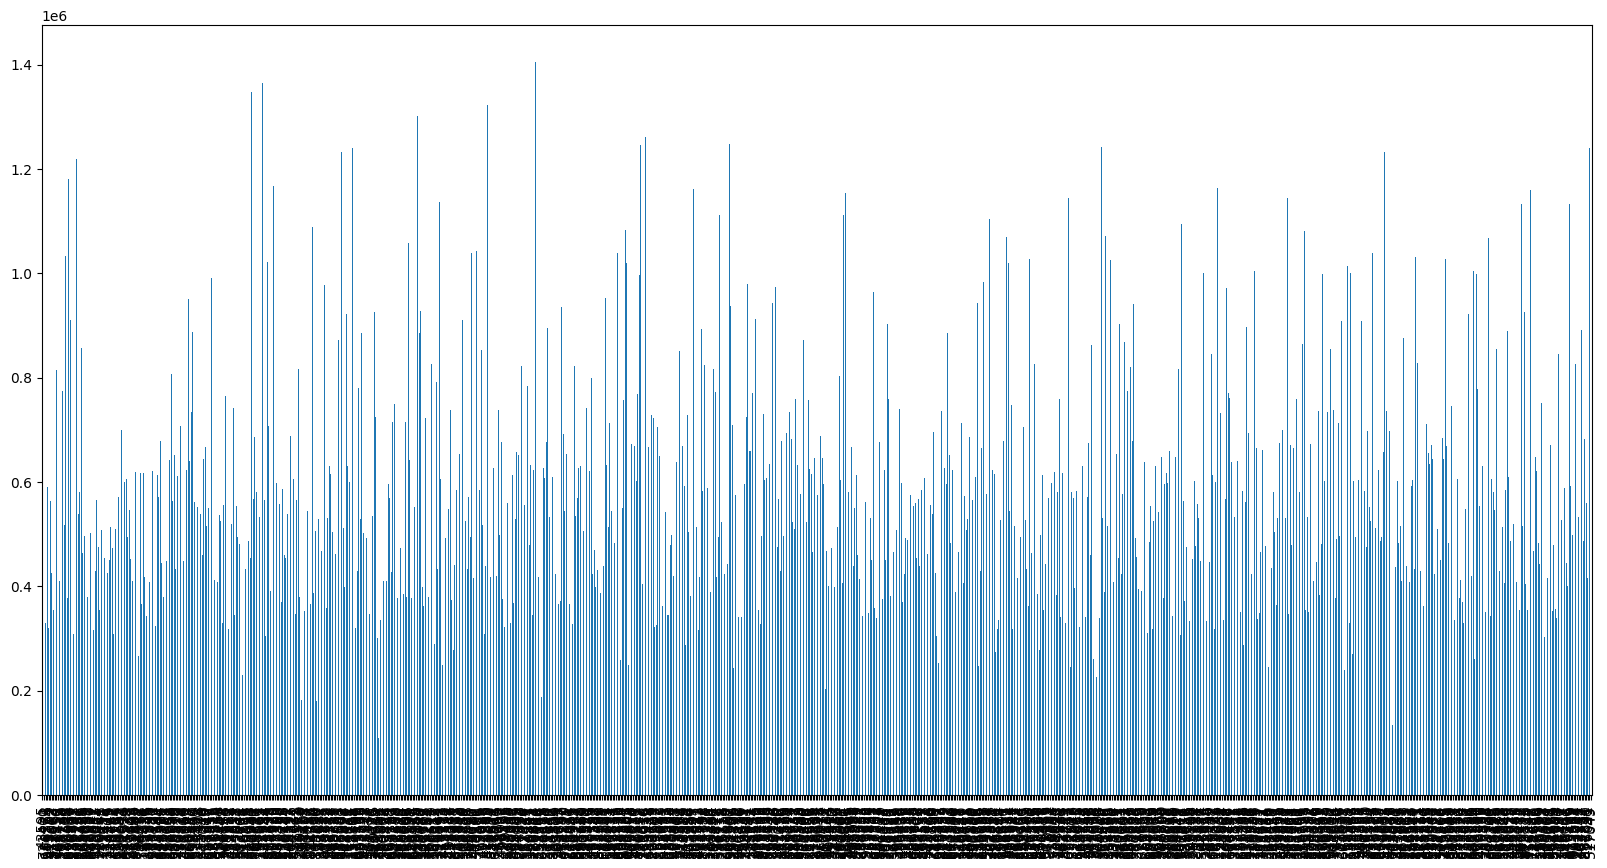

In [57]:
# Create a bar plot with 'adjusted_price' column
df_sample = df_1.sample(n=1000)  # Sample 1000 rows to shorter the excution time
df_sample['adjusted_price'].plot.bar()

* The resulting bar plot have bars corresponding to each row or entry in the DataFrame, showcasing the 'adjusted_price' values.

* Bar plots are commonly used to visualize the distribution or variation of a numerical variable across different categories or data points.

* But we have a large dataset, a bar plot of every individual data point is overwhelming and not informative.

* This had proven that we should use scatter matrix as below.

array([[<Axes: xlabel='longitude', ylabel='longitude'>,
        <Axes: xlabel='latitude', ylabel='longitude'>,
        <Axes: xlabel='distance_from_cbd', ylabel='longitude'>,
        <Axes: xlabel='floor_area_sqm', ylabel='longitude'>,
        <Axes: xlabel='median_storey', ylabel='longitude'>,
        <Axes: xlabel='remaining_lease', ylabel='longitude'>,
        <Axes: xlabel='flat_type', ylabel='longitude'>,
        <Axes: xlabel='adjusted_price', ylabel='longitude'>],
       [<Axes: xlabel='longitude', ylabel='latitude'>,
        <Axes: xlabel='latitude', ylabel='latitude'>,
        <Axes: xlabel='distance_from_cbd', ylabel='latitude'>,
        <Axes: xlabel='floor_area_sqm', ylabel='latitude'>,
        <Axes: xlabel='median_storey', ylabel='latitude'>,
        <Axes: xlabel='remaining_lease', ylabel='latitude'>,
        <Axes: xlabel='flat_type', ylabel='latitude'>,
        <Axes: xlabel='adjusted_price', ylabel='latitude'>],
       [<Axes: xlabel='longitude', ylabel='distance_from

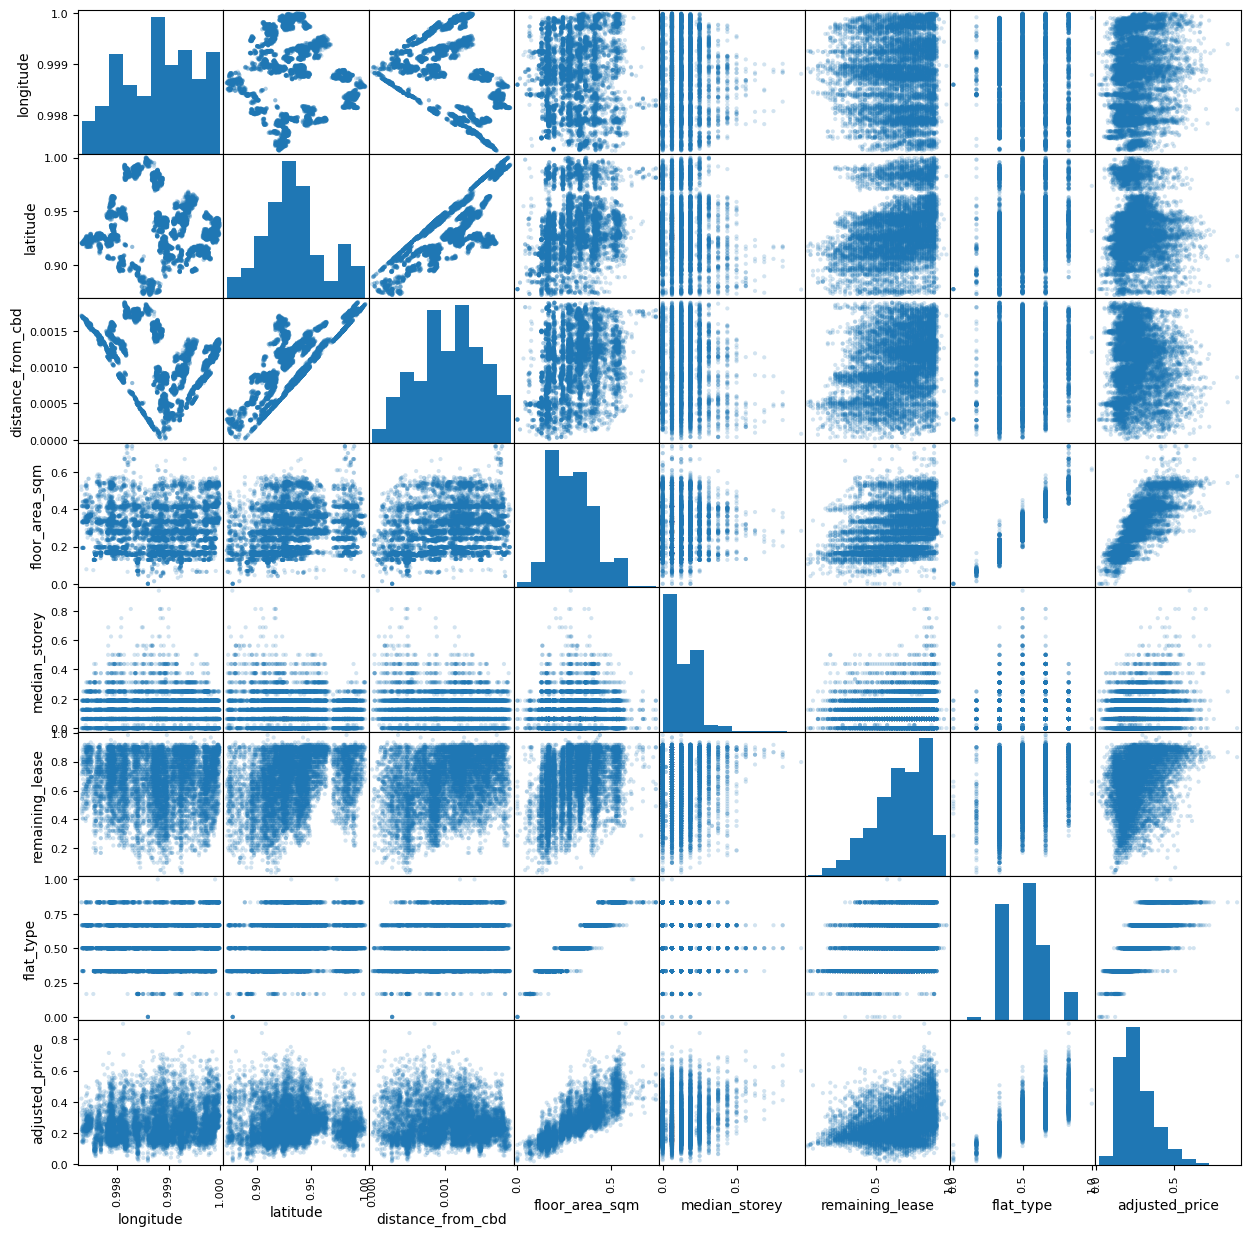

In [58]:
# Gets all the columns with numerical values
df_numerical = df_norm_min_max.select_dtypes(include=['float64']).sample(10000) # Sample 10000 rows to reduce the excution time.

# Create a scatter matrix for the numerical columns
pd.plotting.scatter_matrix(df_numerical,alpha=0.2,figsize=(15,15))

* The scatter matrix provides a visual overview of the relationships between pairs of numerical variables in the dataset.

* Each cell in the matrix represents a scatter plot of two variables and the diagonal cells show the distribution of individual variables.

* This visualization is useful for identifying patterns, correlations and potential outliers in the data.

<Axes: >

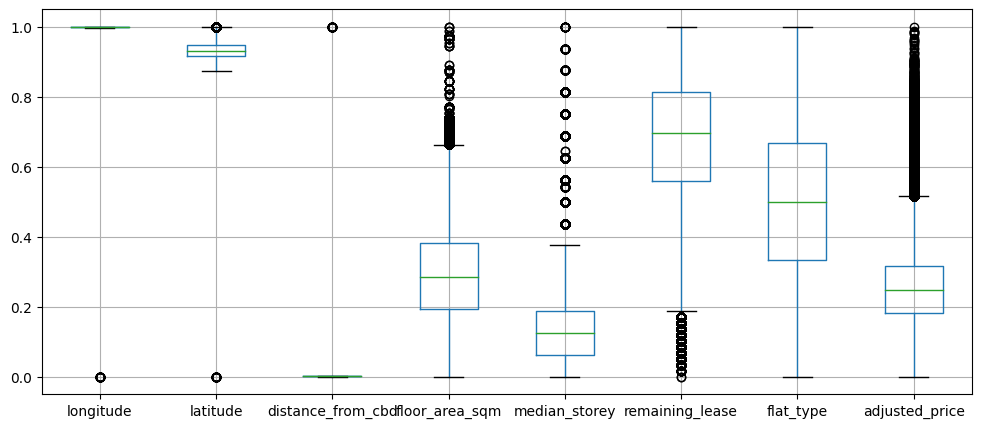

In [59]:
# Create a boxplot for each numerical column in df_numerical
df_numerical_box = df_norm_min_max.select_dtypes(include=['float64'])
df_numerical_box.boxplot(figsize=(12,5))

* Each box represents the interquartile range (IQR) of the data with a line inside the box indicating the median.

* The "whiskers" extend to the minimum and maximum values within a certain range and any points beyond the whiskers are considered potential outliers.

* This visualization is helpful for identifying the central tendency, spread and presence of outliers in each numerical variable of the dataset.

* It provides a quick and effective way to understand the distribution of the data across different features.

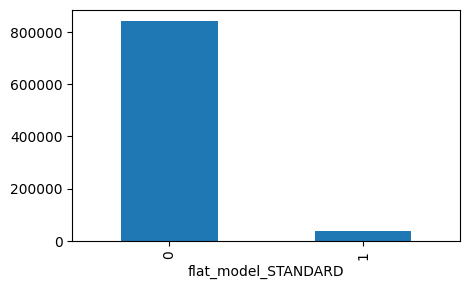

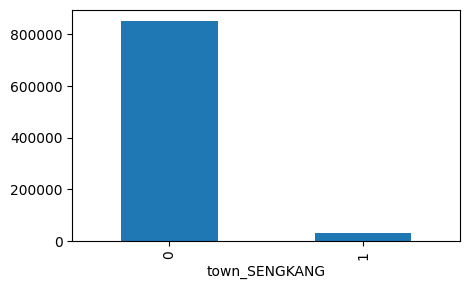

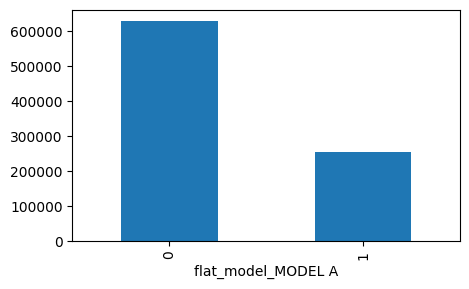

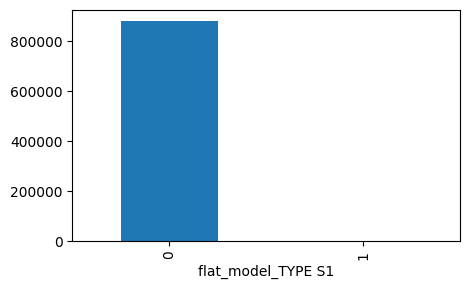

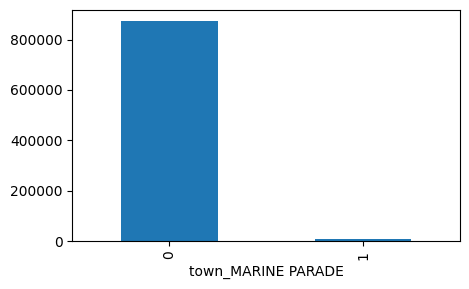

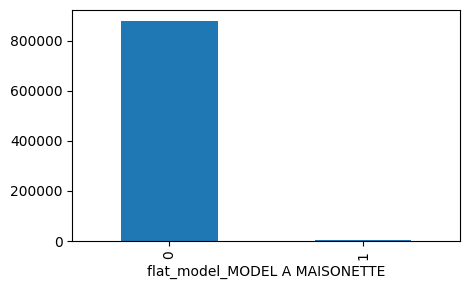

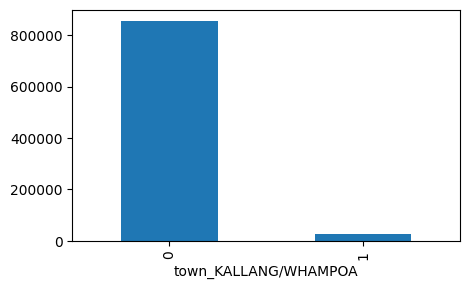

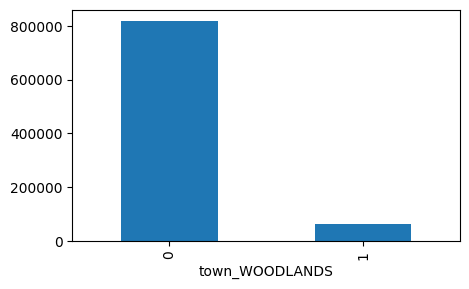

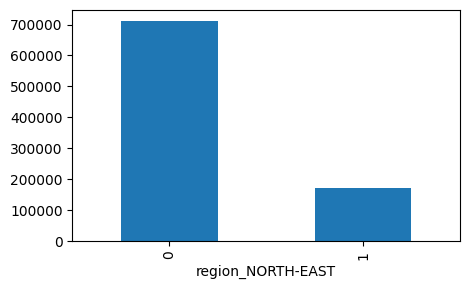

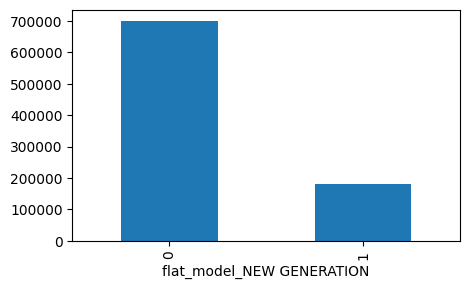

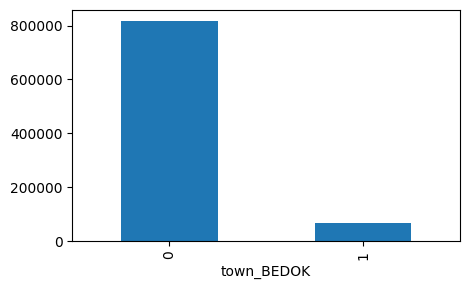

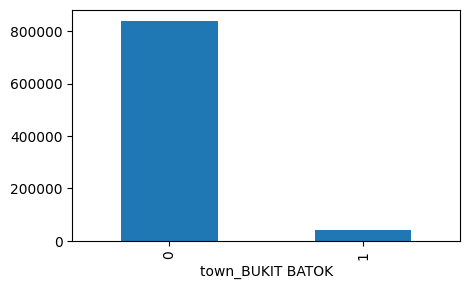

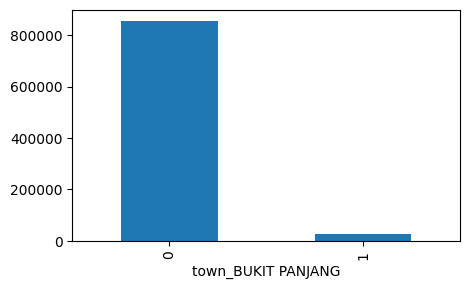

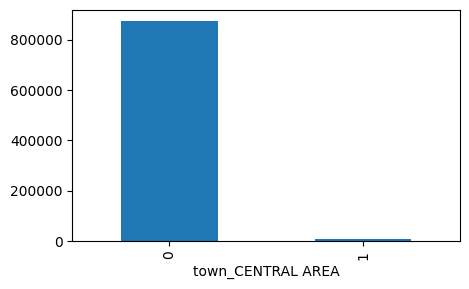

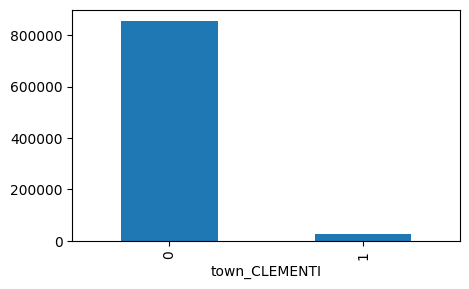

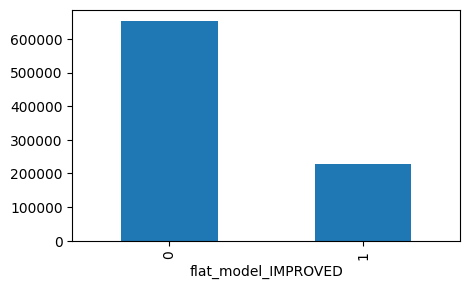

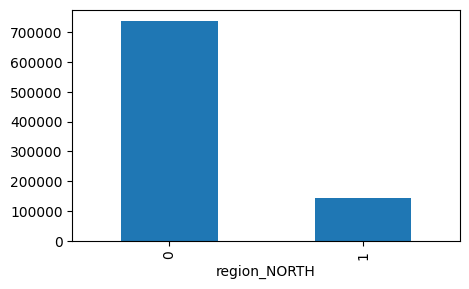

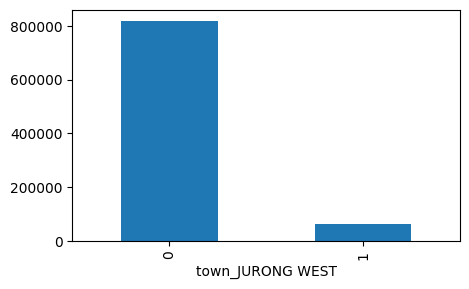

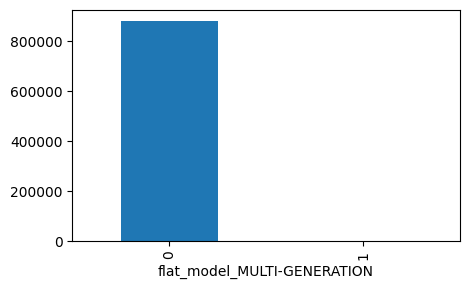

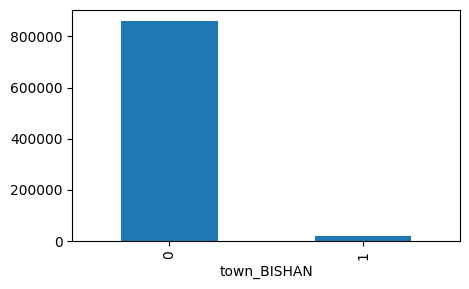

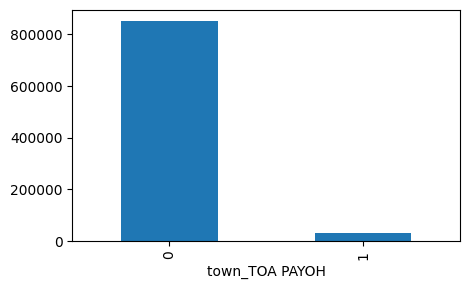

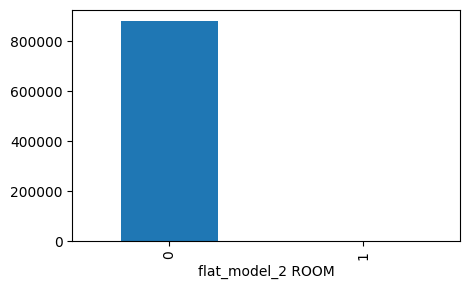

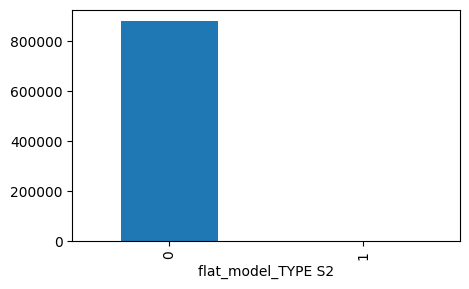

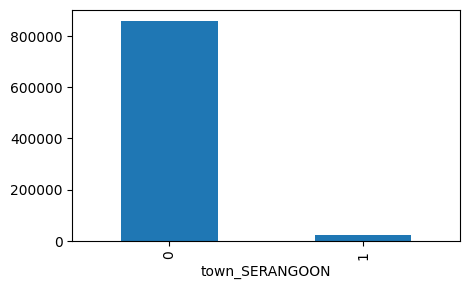

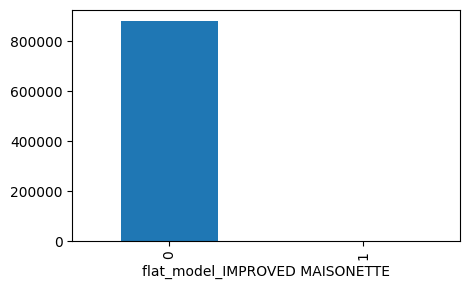

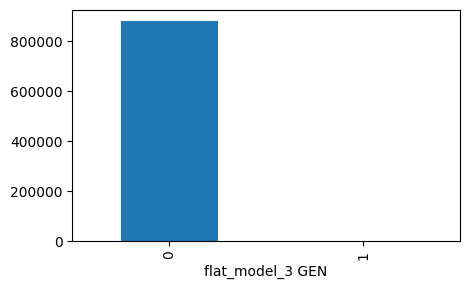

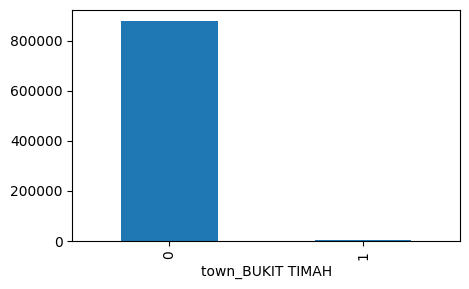

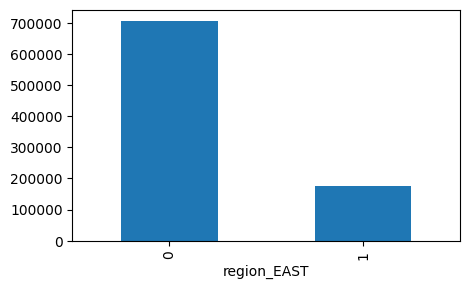

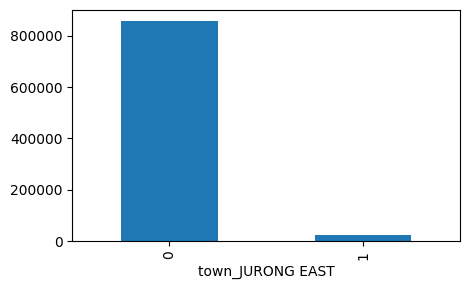

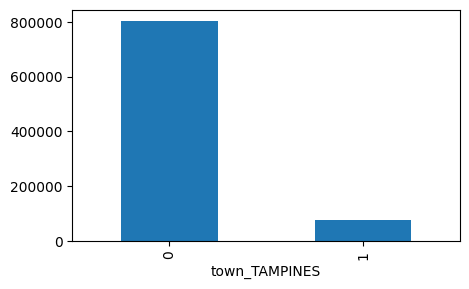

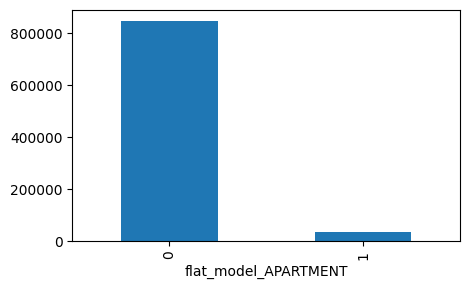

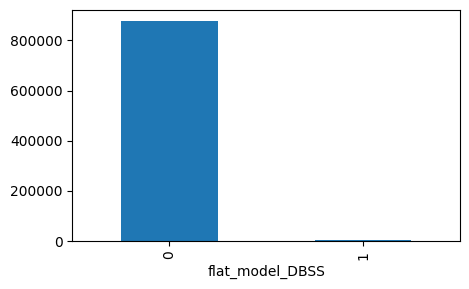

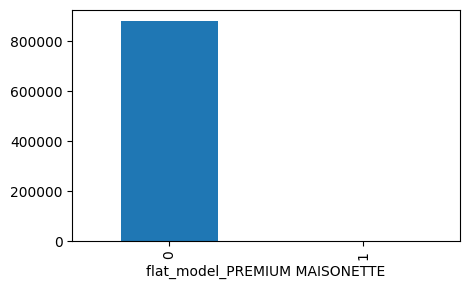

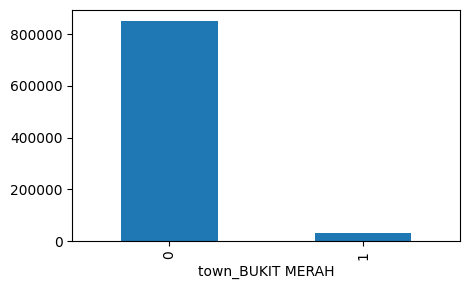

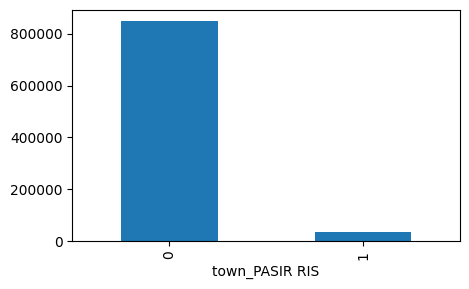

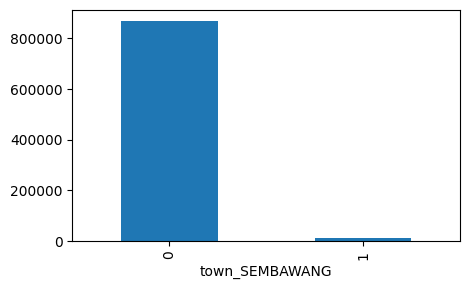

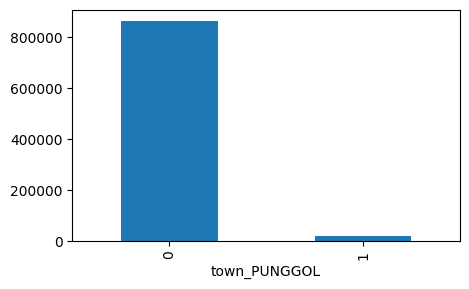

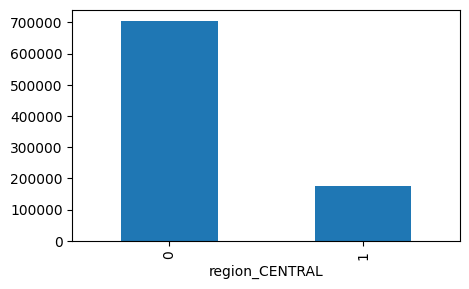

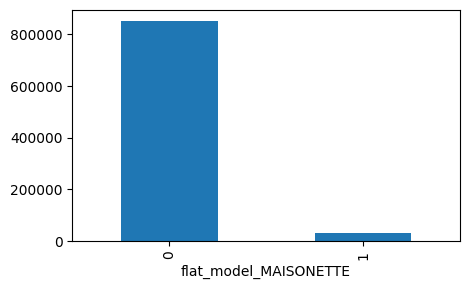

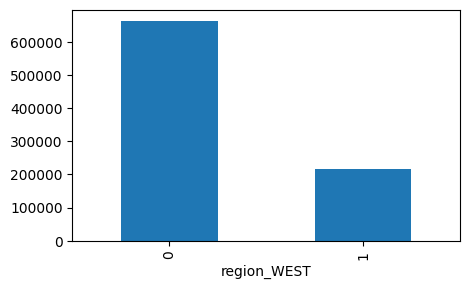

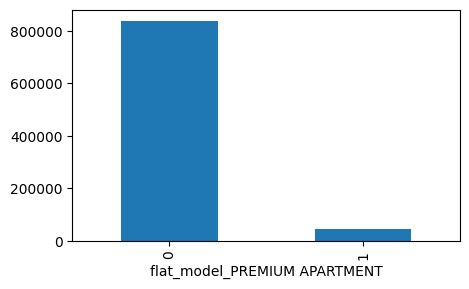

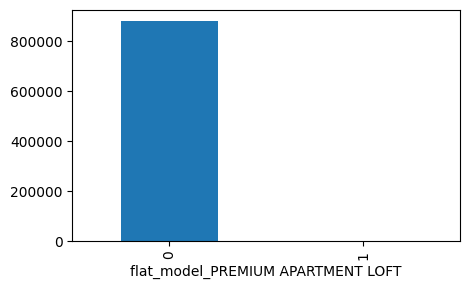

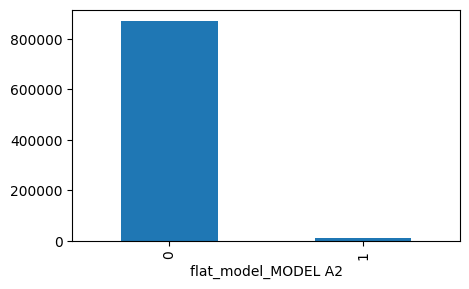

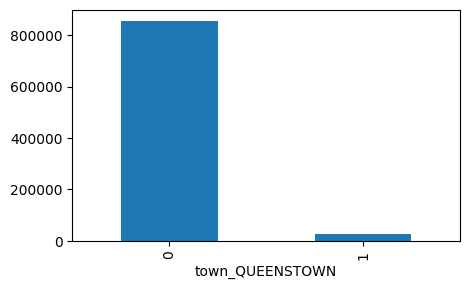

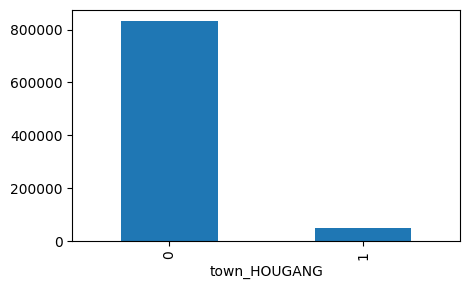

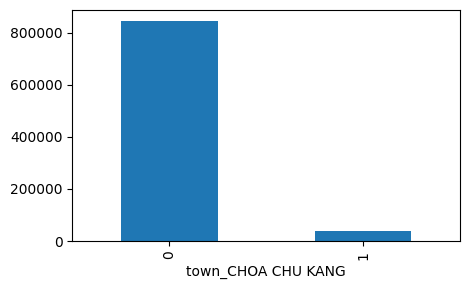

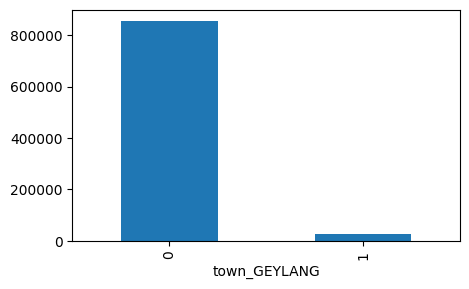

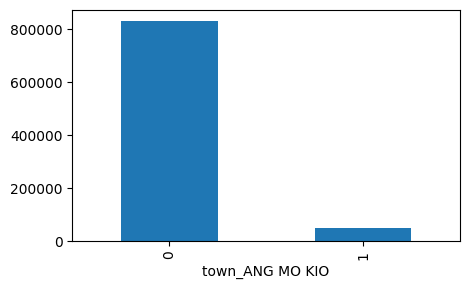

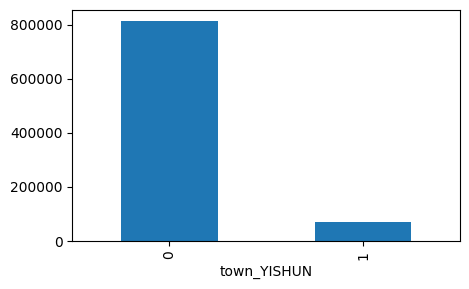

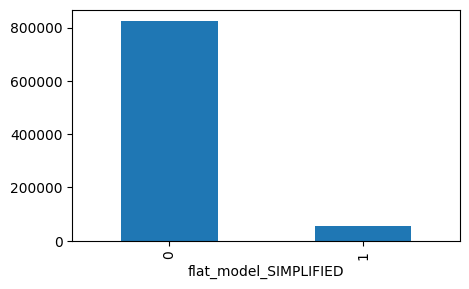

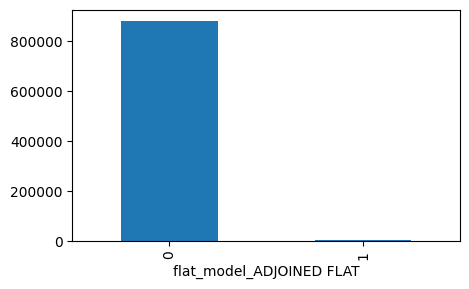

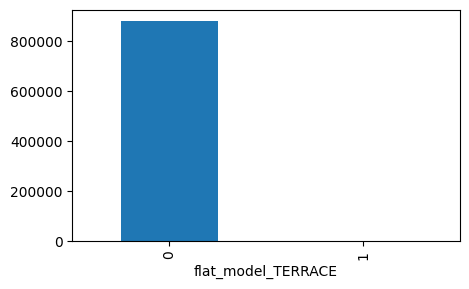

In [60]:
import matplotlib.pyplot as plt

# Takes a list of the dataframe columns
cols = df_1.columns

# Filter out categorical columns form the list of cols
categorical = list(set(cols) - set(df_numerical))

# Creates a dataframe only with categorical columns
df_categorical = df_1[categorical]

for col in df_categorical.columns:
    # Counting the unique values in a column
    n_unique = df_categorical[col].nunique()

    # Execute statement below only if the column has <= 10 unique values
    if(n_unique<=10):
      # Count/categorize the number of samples in a unique value and plot it as a bar
      df_categorical[col].value_counts().plot(kind='bar',figsize=(5,3))
      plt.show()

* This code is particularly useful for visualizing the distribution of categorical variables with a small number of unique values, allowing us to understand the frequency of each category in the dataset.

**The Dataset is now done with data pre-processing**

# 2.0 Model Selection

Since the dataset is already prepared with features and target variable, we can directly jump into the model selection process.

1. Model Selection: Choose appropriate regression models.
2. Hyperparameter Tuning: Tune the hyperparameters of selected models.
3. Training: Train the models on the training data.
4. Evaluation: Evaluate the models using appropriate metrics.



Model Selection:
1. **Linear Regression**: Models the relationship between a dependent variable and one or more independent variables by fitting a linear equation to observed data.

2. **Ridge Regression**: A type of linear regression that includes a regularization term (penalty) to prevent overfitting by shrinking the regression coefficients.

3. **Decision Trees Regression**: Uses a tree-like model of decisions to split the data into subsets based on the feature values, making predictions by averaging the values in the leaf nodes.

4. **K-Nearest Neighbors Regression**: Predicts the value of a data point based on the average values of its k-nearest neighbors in the feature space.

5. **Linear Support Vector Regression**: A version of SVR that assumes a linear relationship between the features and the target, fitting a linear hyperplane with a margin.

6. **Random Forest Regression**: Uses an ensemble of decision trees to make predictions, averaging the results of multiple trees to improve accuracy and reduce overfitting.


## 2.1 Early sense of the latest dataset before perform train_test split

In [61]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882024 entries, 0 to 924718
Data columns (total 60 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   longitude                          882024 non-null  float64
 1   latitude                           882024 non-null  float64
 2   distance_from_cbd                  882024 non-null  float64
 3   floor_area_sqm                     882024 non-null  float64
 4   median_storey                      882024 non-null  float64
 5   remaining_lease                    882024 non-null  float64
 6   flat_type                          882024 non-null  float64
 7   town_ANG MO KIO                    882024 non-null  uint8  
 8   town_BEDOK                         882024 non-null  uint8  
 9   town_BISHAN                        882024 non-null  uint8  
 10  town_BUKIT BATOK                   882024 non-null  uint8  
 11  town_BUKIT MERAH                   882024 no

In [62]:
df_model = df_1.sample(100000)
df_model.head()

longitude  latitude  distance_from_cbd  floor_area_sqm  median_storey  \
739258   0.183745 -0.300561           0.000464        0.360449       0.064728   
703427  -0.003987  1.422078           0.060620        1.406376       0.687410   
593539   0.170824  0.340986           0.026152        1.018996       0.064728   
262536  -0.121733  0.484289           0.039945        0.592878       1.932775   
808059   0.019256  1.516973           0.066316        0.321711      -1.180637   

        remaining_lease  flat_type  town_ANG MO KIO  town_BEDOK  town_BISHAN  \
739258         0.736019        3.0                0           0            0   
703427         0.923085        4.0                0           0            0   
593539         0.268353        4.0                0           0            0   
262536         0.455419        4.0                0           0            0   
808059         0.829552        3.0                0           0            0   

        town_BUKIT BATOK  town_BUKIT MERAH  town_BUKIT PANJANG  \
739258                 0                 0                   0   
703427                 0                 0                   0   
593539                 0                 0                   0   
262536                 0                 0                   1   
808059                 0                 0                   0   

        town_BUKIT TIMAH  town_CENTRAL AREA  town_CHOA CHU KANG  \
739258                 0                  0                   0   
703427                 0                  0                   0   
593539                 0                  0                   0   
262536                 0                  0                   0   
808059                 0                  0                   0   

        town_CLEMENTI  town_GEYLANG  town_HOUGANG  town_JURONG EAST  \
739258              0             0             0                 0   
703427              0             0             0                 0   
593539              0             0             0                 0   
262536              0             0             0                 0   
808059              0             0             0                 0   

        town_JURONG WEST  town_KALLANG/WHAMPOA  town_MARINE PARADE  \
739258                 0                     0                   0   
703427                 0                     0                   0   
593539                 0                     0                   0   
262536                 0                     0                   0   
808059                 0                     0                   0   

        town_PASIR RIS  town_PUNGGOL  town_QUEENSTOWN  town_SEMBAWANG  \
739258               0             0                0               0   
703427               0             0                0               0   
593539               1             0                0               0   
262536               0             0                0               0   
808059               0             0                0               0   

        town_SENGKANG  town_SERANGOON  town_TAMPINES  town_TOA PAYOH  \
739258              0               0              1               0   
703427              0               0              0               0   
593539              0               0              0               0   
262536              0               0              0               0   
808059              0               0              0               0   

        town_WOODLANDS  town_YISHUN  flat_model_2 ROOM  flat_model_3 GEN  \
739258               0            0                  0                 0   
703427               0            1                  0                 0   
593539               0            0                  0                 0   
262536               0            0                  0                 0   
808059               0            1                  0                 0   

        flat_model_ADJOINED FLAT  flat_model_APARTMENT  flat_mo

* The overwhelming size of the dataset will complicate the process of model training and testing.
* As such we randomly picked only 100000 entries from the entire dataset for our model.
* The 100000 random entries is inserted into a new dataset named df_model.



In [63]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 739258 to 29491
Data columns (total 60 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   longitude                          100000 non-null  float64
 1   latitude                           100000 non-null  float64
 2   distance_from_cbd                  100000 non-null  float64
 3   floor_area_sqm                     100000 non-null  float64
 4   median_storey                      100000 non-null  float64
 5   remaining_lease                    100000 non-null  float64
 6   flat_type                          100000 non-null  float64
 7   town_ANG MO KIO                    100000 non-null  uint8  
 8   town_BEDOK                         100000 non-null  uint8  
 9   town_BISHAN                        100000 non-null  uint8  
 10  town_BUKIT BATOK                   100000 non-null  uint8  
 11  town_BUKIT MERAH                   10000

* Making sure the new dataset have 100000 entries and all the attributes of the original dataset.

In [64]:
df_model.isnull().sum()

longitude                            0
latitude                             0
distance_from_cbd                    0
floor_area_sqm                       0
median_storey                        0
remaining_lease                      0
flat_type                            0
town_ANG MO KIO                      0
town_BEDOK                           0
town_BISHAN                          0
town_BUKIT BATOK                     0
town_BUKIT MERAH                     0
town_BUKIT PANJANG                   0
town_BUKIT TIMAH                     0
town_CENTRAL AREA                    0
town_CHOA CHU KANG                   0
town_CLEMENTI                        0
town_GEYLANG                         0
town_HOUGANG                         0
town_JURONG EAST                     0
town_JURONG WEST                     0
town_KALLANG/WHAMPOA                 0
town_MARINE PARADE                   0
town_PASIR RIS                       0
town_PUNGGOL                         0
town_QUEENSTOWN          

* Making sure there are no missing value in df_model dataset.

## 2.2 Performs train-test split

In [65]:
# Import necessary libraries
import pickle
from sklearn.model_selection import train_test_split

In [66]:
df_model.describe()

longitude       latitude  distance_from_cbd  floor_area_sqm  \
count  100000.000000  100000.000000      100000.000000   100000.000000   
mean        0.000477      -0.005488          -0.000893        0.023697   
std         0.938766       0.996957           0.938151        0.994240   
min      -169.964924     -32.179751          -0.188541       -2.506165   
25%        -0.103312      -0.661743          -0.053425       -0.879168   
50%         0.011807      -0.169304           0.002816       -0.065669   
75%         0.102304       0.475736           0.049360        0.709092   
max         0.210394       2.237272         170.753981        5.706298   

       median_storey  remaining_lease      flat_type  town_ANG MO KIO  \
count  100000.000000    100000.000000  100000.000000    100000.000000   
mean       -0.001445         0.030970       3.032290         0.056540   
std         0.996621         0.978767       0.943163         0.230963   
min        -1.180637        -3.566506       0.000000         0.000000   
25%        -0.557955        -0.573445       2.000000         0.000000   
50%         0.064728         0.174820       3.000000         0.000000   
75%         0.687410         0.829552       4.000000         0.000000   
max         8.782281         1.858416       6.000000         1.000000   

          town_BEDOK    town_BISHAN  town_BUKIT BATOK  town_BUKIT MERAH  \
count  100000.000000  100000.000000     100000.000000     100000.000000   
mean        0.072780       0.024070          0.048330          0.034450   
std         0.259776       0.153267          0.214464          0.182383   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          0.000000          0.000000   
50%         0.000000       0.000000          0.000000          0.000000   
75%         0.000000       0.000000          0.000000          0.000000   
max         1.000000       1.000000          1.000000          1.000000   

       town_BUKIT PANJANG  town_BUKIT TIMAH  town_CENTRAL AREA  \
count       100000.000000     100000.000000      100000.000000   
mean             0.030860          0.002770           0.007320   
std              0.172939          0.052558           0.085244   
min              0.000000          0.000000           0.000000   
25%              0.000000          0.000000           0.000000   
50%              0.000000          0.000000           0.000000   
75%              0.000000          0.000000           0.000000   
max              1.000000          1.000000           1.000000   

       town_CHOA CHU KANG  town_CLEMENTI  town_GEYLANG   town_HOUGANG  \
count       100000.000000  100000.000000  100000.00000  100000.000000   
mean             0.041520       0.029230       0.03096       0.054360   
std              0.199491       0.168451       0.17321       0.226728   
min              0.000000       0.000000       0.00000       0.000000   
25%              0.000000       0.000000       0.00000       0.000000   
50%              0.000000       0.000000       0.00000       0.000000   
75%              0.000000       0.000000       0.00000       0.000000   
max              1.000000       1.000000       1.00000       1.000000   

       town_JURONG EAST  town_JURONG WEST  town_KALLANG/WHAMPOA  \
count     100000.000000     100000.000000         100000.000000   
mean           0.027040          0.070890              0.029540   
std            0.162201          0.256642              0.169315   
min            0.000000          0.000000              0.000000   
25%            0.000000          0.000000              0.000000   
50%            0.000000          0.000000              0.000000   
75%            0.000000          0.000000              0.000000   
max            1.000000          1.000000              1.000000   

       town_MARINE PARADE  town_PASIR RIS   town_PUNGGOL  town_QUEENSTOWN  \
count       100000.000000   100000.000000  100000.000000    100000.000000   

In [67]:
# Shuffle and split dataset randomly into 80% training and 20% test, then split training into 80% training and 20% validation
train, test = train_test_split(df_model, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [68]:
# Validate that the split is correct
print("Train size: ", len(train))
print("Validation size: ", len(val))
print("Test size: ", len(test))

# Validate that the split is a representative sample of the original dataset
print("Train mean: ", train["adjusted_price"].mean())
print("Validation mean: ", val["adjusted_price"].mean())
print("Test mean: ", test["adjusted_price"].mean())

Train size:  64000
Validation size:  16000
Test size:  20000
Train mean:  579984.5435994997
Validation mean:  579599.3176200144
Test mean:  576847.2902641951


## 2.3 Splitting features into X(features) and Y(target output)

In [69]:
# Split into X and y
X_train = train.drop(columns=["adjusted_price"])
y_train = train["adjusted_price"]

X_val = val.drop(columns=["adjusted_price"])
y_val = val["adjusted_price"]

X_test = test.drop(columns=["adjusted_price"])
y_test = test["adjusted_price"]

# 3.0 Model Training

## 3.1 MSE, MAE, MPE of Train Set & f_regression scores

In [70]:
# Import necessary libraries for all models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [71]:
# Lists of model evaluation scores
models = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []

# Define a function to store model evaluation scores
def model_scores(model, MSE, RMSE, MAE, MAPE):
  models.append(model)
  MSE_scores.append(MSE)
  RMSE_scores.append(RMSE)
  MAE_scores.append(MAE)
  MAPE_scores.append(MAPE)


In [72]:
# Get MSE, MAE and MPE for model where we predict the mean of the training set
mean = y_train.mean()
y_pred = np.full(len(y_val), mean)

# Print model evaluation score
MSE = mean_squared_error(y_val, y_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_pred)
MAPE = mean_absolute_percentage_error(y_val, y_pred)

print("MSE: ", MSE)
print("RMSE: ", RMSE)
print("MAE: ", MAE)
print("MAPE: ", MAPE)

MSE:  50495896669.60692
RMSE:  224712.92056667974
MAE:  173427.9935023772
MAPE:  0.3496292319140865


In [73]:
# Calculate f_regression scores for each feature
from sklearn.feature_selection import f_regression

# Sort feature names by f_regression scores
feature_names = X_train.columns
scores = f_regression(X_train, y_train)[0]
feature_scores = pd.DataFrame({"feature": feature_names, "score": scores})
feature_scores.sort_values(by="score", ascending=False)

feature          score
3                      floor_area_sqm  130410.354003
6                           flat_type  123354.134209
40              flat_model_MAISONETTE    8709.533451
5                     remaining_lease    7944.618060
36               flat_model_APARTMENT    7779.758326
45          flat_model_NEW GENERATION    7630.731032
4                       median_storey    3231.216311
23                     town_PASIR RIS    1719.064883
49              flat_model_SIMPLIFIED    1566.081040
9                         town_BISHAN    1490.217978
55                        region_EAST     735.407641
7                     town_ANG MO KIO     615.284251
29                      town_TAMPINES     597.259487
56                       region_NORTH     569.244630
32                        town_YISHUN     496.408018
37                    flat_model_DBSS     488.291397
38                flat_model_IMPROVED     480.321607
42      flat_model_MODEL A MAISONETTE     374.971216
58                        region_WEST     262.135331
54                     region_CENTRAL     247.022222
46       flat_model_PREMIUM APARTMENT     245.516249
50                flat_model_STANDARD     243.052875
8                          town_BEDOK     222.309530
13                   town_BUKIT TIMAH     214.595629
44        flat_model_MULTI-GENERATION     213.404106
20                   town_JURONG WEST     197.725895
51                 flat_model_TERRACE     178.509273
53                 flat_model_TYPE S2     174.211651
52                 flat_model_TYPE S1     165.444673
10                   town_BUKIT BATOK     149.197248
11                   town_BUKIT MERAH     129.237612
35           flat_model_ADJOINED FLAT     115.273018
1                            latitude     108.150061
17                       town_GEYLANG     107.750521
31                     town_WOODLANDS     103.446339
22                 town_MARINE PARADE      97.993890
28                     town_SERANGOON      92.401059
15                 town_CHOA CHU KANG      83.362974
43                flat_model_MODEL A2      79.220330
25                    town_QUEENSTOWN      61.615061
24                       town_PUNGGOL      45.578669
19                   town_JURONG EAST      42.060294
47  flat_model_PREMIUM APARTMENT LOFT      41.904668
27                      town_SENGKANG      41.770989
16                      town_CLEMENTI      37.096993
39     flat_model_IMPROVED MAISONETTE      32.497205
0                           longitude      31.467670
48      flat_model_PREMIUM MAISONETTE      29.897532
30                     town_TOA PAYOH      12.370826
18                       town_HOUGANG      12.082629
57                  region_NORTH-EAST      11.100273
41                 flat_model_MODEL A      10.632432
12                 town_BUKIT PANJANG       7.843934
33                  flat_model_2 ROOM       7.598644
14                  town_CENTRAL AREA       5.287463
26                     town_SEMBAWANG       3.853648
21               town_KALLANG/WHAMPOA       1.739397
2                   distance_from_cbd       1.520663
34                   flat_model_3 GEN       0.000000

## 3.2 Linear Regression Model

In [74]:
# Train Linear Regression and evaluate on validation set
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_val_pred = lin_reg.predict(X_val)

# Store model evaluation score
MSE = mean_squared_error(y_val, y_val_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_val_pred)
MAPE = mean_absolute_percentage_error(y_val, y_val_pred)
model_scores(lin_reg, MSE, RMSE, MAE, MAPE)

# Print model evaluation score
print("MSE for linear regression model 1 =>", MSE)
print("RMSE for linear regression model 1 =>", RMSE)
print("MAE for linear regression model 1 =>", MAE)
print("MAPE for linear regression model 1 =>", MAPE)

MSE for linear regression model 1 => 8708244737.85975
RMSE for linear regression model 1 => 93317.97649895625
MAE for linear regression model 1 => 69914.86048398554
MAPE for linear regression model 1 => 0.1370890490524537


## 3.3 Ridge Regression Model

In [75]:
# Train Ridge Regression and evalue on validation set
from sklearn.linear_model import Ridge

# Create Ridge Regression model with alpha value of 1,10,100,1000,10000,100000
rr1 = Ridge(alpha=1).fit(X_train, y_train)
rr10 = Ridge(alpha=10).fit(X_train, y_train)
rr100 = Ridge(alpha=100).fit(X_train, y_train)
rr1000 = Ridge(alpha=1000).fit(X_train, y_train)
rr10000 = Ridge(alpha=10000).fit(X_train, y_train)
rr100000 = Ridge(alpha=100000).fit(X_train, y_train)

# Train and find Ridge Regression model with least MAPE score
RidgeRegression = [rr1,rr10,rr100,rr1000,rr10000,rr100000]
bestrr = {}

for x in RidgeRegression:
  y_val_pred = x.predict(X_val)

  # Train and set rr1 as best model at first
  if(x == rr1):
    bestrr['Model'] = x
    bestrr['MSE'] = mean_squared_error(y_val, y_val_pred)
    bestrr['RMSE'] = math.sqrt(bestrr['MSE'])
    bestrr['MAE'] = mean_absolute_error(y_val, y_val_pred)
    bestrr['MAPE'] = mean_absolute_percentage_error(y_val, y_val_pred)
    print("MSE for ridge regression alpha", x.alpha, "=>", bestrr['MSE'])
    print("RMSE for ridge regression alpha", x.alpha, "=>", bestrr['RMSE'])
    print("MAE for ridge regregression alpha", x.alpha, "=>", bestrr['MAE'])
    print("MAPE for ridge regression alpha", x.alpha, "=>", bestrr['MAPE'])
    print()
  # Train next Ridge Regression model in array
  else:
    MSE = mean_squared_error(y_val, y_val_pred)
    RMSE = math.sqrt(MSE)
    MAE = mean_absolute_error(y_val, y_val_pred)
    MAPE = mean_absolute_percentage_error(y_val, y_val_pred)
    print("MSE for ridge regression alpha", x.alpha, "=>", MSE)
    print("RMSE for ridge regression alpha", x.alpha, "=>", RMSE)
    print("MAE for ridge regregression alpha", x.alpha, "=>", MAE)
    print("MAPE for ridge regression alpha", x.alpha, "=>", MAPE)
    print()
    # Check if next Ridge Regression model is better than current best model
    if(MAPE < bestrr['MAPE']):
      bestrr['Model'] = x
      bestrr['MSE'] = MSE
      bestrr['RMSE'] = RMSE
      bestrr['MAE'] = MAE
      bestrr['MAPE'] = MAPE

print("Best Ridge Regression model: ", bestrr['Model'])

model_scores(bestrr['Model'], bestrr['MSE'], bestrr['RMSE'], bestrr['MAE'], bestrr['MAPE'])


MSE for ridge regression alpha 1 => 8709692608.632242
RMSE for ridge regression alpha 1 => 93325.73390352867
MAE for ridge regregression alpha 1 => 69910.81531493075
MAPE for ridge regression alpha 1 => 0.1370894008870835

MSE for ridge regression alpha 10 => 8729554228.66146
RMSE for ridge regression alpha 10 => 93432.08350808335
MAE for ridge regregression alpha 10 => 69953.77764521418
MAPE for ridge regression alpha 10 => 0.1372118038117099

MSE for ridge regression alpha 100 => 8843216209.190159
RMSE for ridge regression alpha 100 => 94038.37625772873
MAE for ridge regregression alpha 100 => 70300.71464145374
MAPE for ridge regression alpha 100 => 0.13779656502134355

MSE for ridge regression alpha 1000 => 9164708263.971613
RMSE for ridge regression alpha 1000 => 95732.48280480149
MAE for ridge regregression alpha 1000 => 71182.03177965268
MAPE for ridge regression alpha 1000 => 0.1385163130693772

MSE for ridge regression alpha 10000 => 10462894139.117306
RMSE for ridge regression

## 3.4 Decision Tree Regression Model

In [76]:
# Train Decison Tree Regressor and evaluate on validation set
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
y_val_pred = tree_reg.predict(X_val)

# Store model evaluation score
MSE = mean_squared_error(y_val, y_val_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_val_pred)
MAPE = mean_absolute_percentage_error(y_val, y_val_pred)
model_scores(tree_reg, MSE, RMSE, MAE, MAPE)

# Print model evaluation score
print("MSE for decision tree regression model 1 =>", MSE)
print("RMSE for decision tree regression model 1 =>", RMSE)
print("MAE for decision tree regression model 1 =>", MAE)
print("MAPE for decision tree regression model 1 =>", MAPE)

# Print depth of Decision Tree Regressor model
print()
print("Decision Tree depth:", tree_reg.get_depth())

MSE for decision tree regression model 1 => 5148813471.136066
RMSE for decision tree regression model 1 => 71755.23305749948
MAE for decision tree regression model 1 => 47738.874758775644
MAPE for decision tree regression model 1 => 0.08535631596946172

Decision Tree depth: 48


## 3.5 K-Nearest Neighbors Regression Model

In [77]:
# train using k-nearest neighbors
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(weights="distance", n_jobs=8).fit(X_train, y_train)
y_val_pred = knn_reg.predict(X_val)

# Store model evaluation score
MSE = mean_squared_error(y_val, y_val_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_val_pred)
MAPE = mean_absolute_percentage_error(y_val, y_val_pred)
model_scores(knn_reg, MSE, RMSE, MAE, MAPE)

# Print model evaluation score
print("MSE for k-nearst neighbors regression model 1 =>", MSE)
print("RMSE for k-nearst neighbors regression model 1 =>", RMSE)
print("MAE for k-nearst neighbors regression model 1 =>", MAE)
print("MAPE for k-nearst neighbors regression model 1 =>", MAPE)

MSE for k-nearst neighbors regression model 1 => 4028141007.654801
RMSE for k-nearst neighbors regression model 1 => 63467.63748285264
MAE for k-nearst neighbors regression model 1 => 42603.35630427692
MAPE for k-nearst neighbors regression model 1 => 0.07624929054049953


## 3.6 Linear Support Vector Regression Model

In [78]:
# # Train Linear support vector regressor and evaluate on validation set
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(random_state=42).fit(X_train, y_train)
y_val_pred = svm_reg.predict(X_val)

# Store model evaluation score
MSE = mean_squared_error(y_val, y_val_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_val_pred)
MAPE = mean_absolute_percentage_error(y_val, y_val_pred)
model_scores(svm_reg, MSE, RMSE, MAE, MAPE)

# Print model evaluation score
print("MSE for linear support vector regression model 1 =>", MSE)
print("RMSE for linear support vector regression model 1 =>", RMSE)
print("MAE for linear support vector regression model 1 =>", MAE)
print("MAPE for linear support vector regression model 1 =>", MAPE)

MSE for linear support vector regression model 1 => 30197788765.173367
RMSE for linear support vector regression model 1 => 173775.10974006998
MAE for linear support vector regression model 1 => 122087.57016880062
MAPE for linear support vector regression model 1 => 0.18744703657015244


## 3.7 Random Forest Regression Model

In [79]:
# Train Random Forest Regressor and evaluate on validation set
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8).fit(X_train, y_train)
y_val_pred = forest_reg.predict(X_val)

# Print model evaluation score
MSE = mean_squared_error(y_val, y_val_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_val, y_val_pred)
MAPE = mean_absolute_percentage_error(y_val, y_val_pred)

print("MSE for random forest regression model 1 =>", MSE)
print("RMSE for random forest regression model 1 =>", RMSE)
print("MAE for random forest regression model 1 =>", MAE)
print("MAPE for random forest regression model 1 =>", MAPE)

MSE for random forest regression model 1 => 2819306664.0756845
RMSE for random forest regression model 1 => 53097.143652702114
MAE for random forest regression model 1 => 35167.36897525121
MAPE for random forest regression model 1 => 0.06369987194847572


In [80]:
# Find the maximum depth of decision trees within a random forest and count the total number of decision trees in that forest
max_depth = 0
for dt_reg in forest_reg.estimators_:
	if dt_reg.get_depth() > max_depth:
		max_depth = dt_reg.get_depth()

print("Maximum depth =>", max_depth)
print("Total number of Decision Trees =>", len(forest_reg.estimators_))

Maximum depth => 55
Total number of Decision Trees => 100


# 4.0 Random Forest Hyperparmeter Tuning

In [81]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [82]:
# Hyperparameter tuning of the number of estimators in a Random Forest Regressor
# Find the optimal number that minimizes prediction errors

errors = []
growing_rf = RandomForestRegressor(n_estimators=1, n_jobs=6,
                                    warm_start=True, random_state=42)
for i in [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 80, 100, 150, 200, 250]:
    growing_rf.n_estimators=i
    growing_rf.fit(X_train, y_train)
    predicted = growing_rf.predict(X_val)
    errors.append(mean_squared_error(y_val, predicted))
    print('Iteration: ', i, 'RMSE Loss: ', math.sqrt(errors[-1]), ' MAE: ', mean_absolute_error(y_val, predicted))

Iteration:  1 RMSE Loss:  75773.31670923375  MAE:  50490.68386517681
Iteration:  5 RMSE Loss:  57967.71128289218  MAE:  38717.10403128758
Iteration:  10 RMSE Loss:  55405.278871145885  MAE:  36802.32042428682
Iteration:  20 RMSE Loss:  54080.097588265606  MAE:  35959.03418013326
Iteration:  25 RMSE Loss:  53780.38040558087  MAE:  35718.61735784031
Iteration:  30 RMSE Loss:  53754.61637817184  MAE:  35651.904150896524
Iteration:  40 RMSE Loss:  53598.38153505368  MAE:  35472.6395566105
Iteration:  50 RMSE Loss:  53380.229570962365  MAE:  35337.71412987211
Iteration:  60 RMSE Loss:  53280.47466530289  MAE:  35285.0771561876
Iteration:  70 RMSE Loss:  53189.72580150219  MAE:  35215.90929341717
Iteration:  80 RMSE Loss:  53134.71094586925  MAE:  35182.54704704993
Iteration:  100 RMSE Loss:  53097.143652702114  MAE:  35167.368975251215
Iteration:  150 RMSE Loss:  53035.41797208972  MAE:  35132.94023351751
Iteration:  200 RMSE Loss:  52979.05619220815  MAE:  35090.02608617856
Iteration:  250

In [83]:
# Hyperparameter tuning of the maximum depth (max_depth) of trees in a Random Forest Regressor
# Find the optimal depth that minimizes prediction errors

errors = []
for i in [1, 5, 10, 15, 20, 25,30, 40, 60, 70]:
    growing_rf = RandomForestRegressor(n_estimators=75, n_jobs=6, random_state=42, max_depth=i)
    growing_rf.fit(X_train, y_train)
    predicted = growing_rf.predict(X_val)
    errors.append(mean_squared_error(y_val, predicted))
    print('Iteration: ', i, 'RMSE Loss: ', math.sqrt(errors[-1]), ' MAE: ', mean_absolute_error(y_val, predicted))

Iteration:  1 RMSE Loss:  163204.13423418475  MAE:  127962.01207642416
Iteration:  5 RMSE Loss:  89623.70265820778  MAE:  66258.12640270872
Iteration:  10 RMSE Loss:  63304.57127342527  MAE:  45361.457458955316
Iteration:  15 RMSE Loss:  54906.808878517404  MAE:  37546.878418895205
Iteration:  20 RMSE Loss:  53245.39769368864  MAE:  35433.40816076711
Iteration:  25 RMSE Loss:  53063.60823583159  MAE:  35162.992032016366
Iteration:  30 RMSE Loss:  53159.72023390762  MAE:  35206.32537287077
Iteration:  40 RMSE Loss:  53215.314498852924  MAE:  35222.12906570996
Iteration:  60 RMSE Loss:  53133.411372128736  MAE:  35190.772046923026
Iteration:  70 RMSE Loss:  53133.411372128736  MAE:  35190.772046923026


#5.0 Final Model Training of best model (Random Forest Regression)

In [84]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math, pickle

# Combine train and validation data
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

In [85]:
# Create Random Forest Model with 75 trees and a max depth of 25

rf = RandomForestRegressor(n_estimators=75, max_depth=25, random_state=42, n_jobs=6)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=75, n_jobs=6, random_state=42)

#6.0 Model Evaluation on Test Model

In [86]:
# Predict on test data
y_pred = rf.predict(X_test)

# Store model evaluation score
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
model_scores(rf, MSE, RMSE, MAE, MAPE)

# Print model evaluation score
print("Mean Squared Error =>", MSE)
print("Root Mean Squared Error =>", RMSE)
print("Mean Absolute Error =>", MAE)
print("Mena Absolute Percentage Error =>", MAPE)

Mean Squared Error => 2672242411.0121336
Root Mean Squared Error => 51693.73667101396
Mean Absolute Error => 34160.89664786275
Mena Absolute Percentage Error => 0.0619444171546345


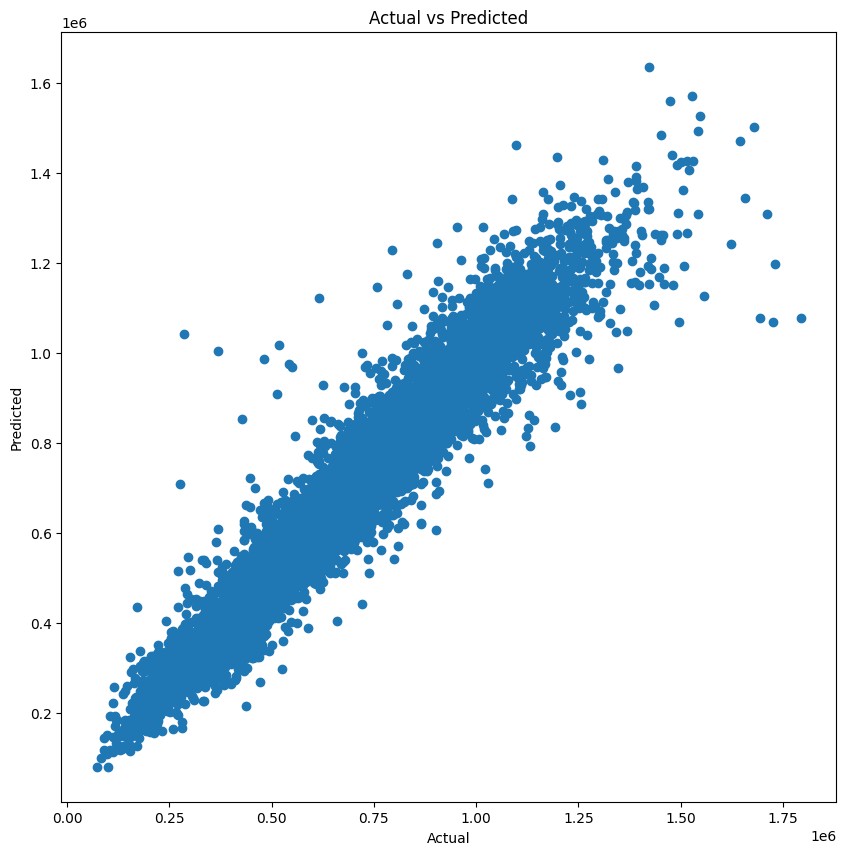

In [87]:
# Creates a scatter plot to visualize the relationship between actual and predicted values from a regression model
# Plot y_pred vs y_test
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

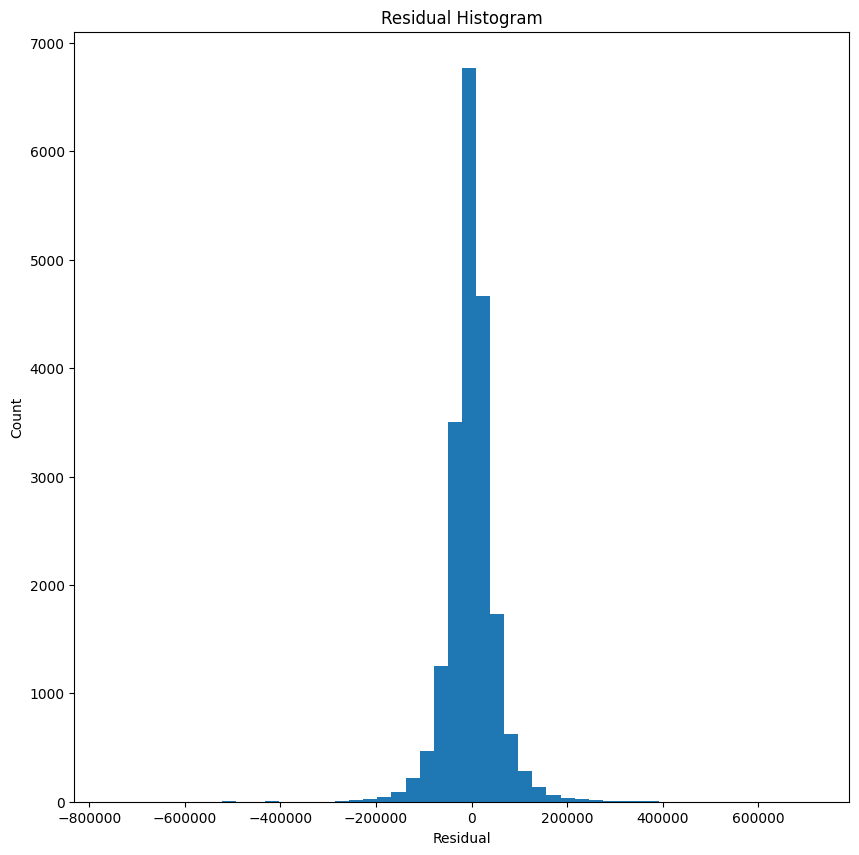

In [88]:
# Creates a histogram to visualize the distribution of residuals (the differences between actual and predicted values) from a regression model
# Plot histogram of residuals
plt.figure(figsize=(10, 10))
plt.hist(y_test - y_pred, bins=50)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Histogram')
plt.show()

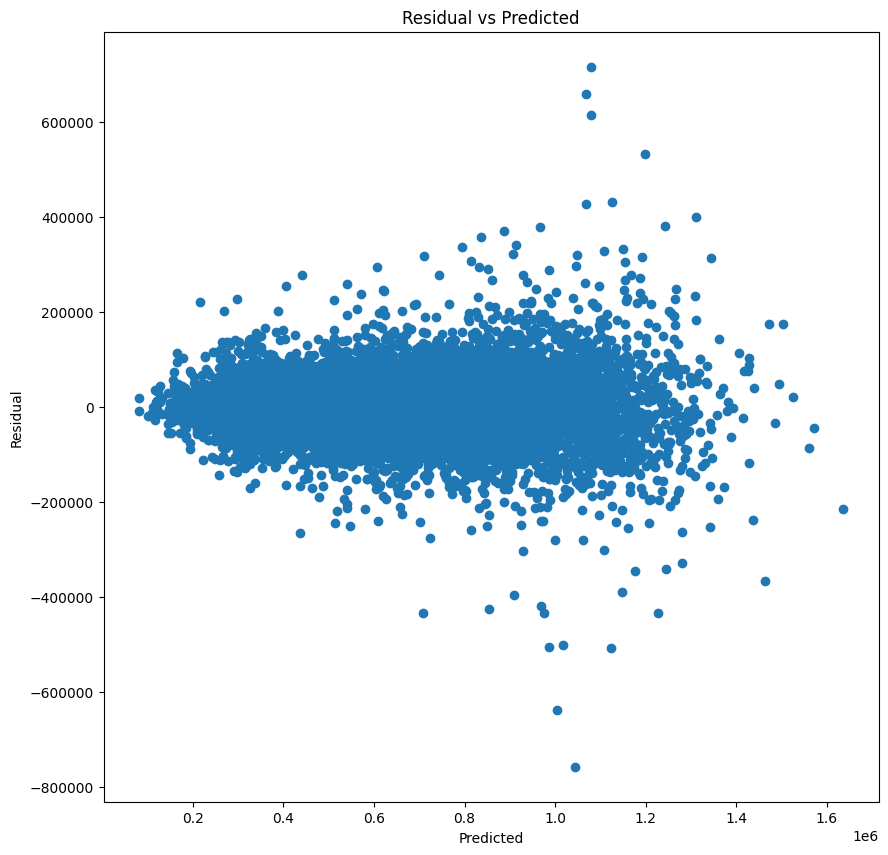

In [89]:
# Creates a scatter plot to visualize the residuals (the differences between actual and predicted values) against the predicted values from a regression model
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual vs Predicted')
plt.show()

For the Machine Learning task we had chosen (Regression), the best evaluation methods are:

1. **MSE (Mean Squared Error)**:
* Best when you want to penalize larger errors more significantly.
* Useful for models where minimizing large errors is critical.

2. **RMSE (Root Mean Squared Error)**:
* Provides error magnitude in the same units as the target variable.
* Good for general understanding of model accuracy.

3. **MAE (Mean Absolute Error)**:
* Less sensitive to outliers compared to MSE and RMSE.
* Good for understanding the average error magnitude directly.

4. **Mean Absolute Percentage Error (MAPE)**:
* Understand errors in percentage terms, especially when comparing errors across different scales.
* Provides a relative measure of prediction accuracy.

# 7.0 Models Comparison

## 7.1 Compared to other model

In [90]:
# Creates a DataFrame to store the performance metrics of different models and sorts these models based on their RMSE scores in ascending order
model_perfs = pd.DataFrame({'Model': models,
                            'MSE_scores': MSE_scores,
                            'RMSE_scores': RMSE_scores,
                            'MAE_scores': MAE_scores,
                            'MAPE_scores': MAPE_scores}).sort_values(by='RMSE_scores',ascending = True).reset_index(drop=True)

model_perfs

Model    MSE_scores  \
0  (DecisionTreeRegressor(max_depth=25, max_featu...  2.672242e+09   
1  KNeighborsRegressor(n_jobs=8, weights='distance')  4.028141e+09   
2             DecisionTreeRegressor(random_state=42)  5.148813e+09   
3                                 LinearRegression()  8.708245e+09   
4                                     Ridge(alpha=1)  8.709693e+09   
5                         LinearSVR(random_state=42)  3.019779e+10   

     RMSE_scores     MAE_scores  MAPE_scores  
0   51693.736671   34160.896648     0.061944  
1   63467.637483   42603.356304     0.076249  
2   71755.233057   47738.874759     0.085356  
3   93317.976499   69914.860484     0.137089  
4   93325.733904   69910.815315     0.137089  
5  173775.109740  122087.570169     0.187447

# 8.0 Conclusion

From the performance metrics of various regression models:

1. **DecisionTreeRegressor(max_depth=25, max_features='sqrt')**:
* This model has the best performance with the lowest MSE (2.67e+09), RMSE (51693.74), MAE (34160.90) and MAPE (0.0619).
* It indicates that this decision tree model with specified hyperparameters is the most accurate among the tested models.

2. **KNeighborsRegressor(n_jobs=8, weights='distance')**:
* This model performs reasonably well, but its RMSE (63467.64) and MAE (42603.36) are higher than the best-performing decision tree model.
* It suggests that while KNN is effective, it is not as precise in this context.

3. **DecisionTreeRegressor(random_state=42)**:
* The basic decision tree regressor has higher error metrics (RMSE: 71755.23, MAE: 47738.87) compared to the tuned decision tree model, indicating the importance of hyperparameter tuning.

4. **LinearRegression and Ridge(alpha=1)**:
* Both linear models have similar performance, with high RMSE (around 93321) and MAE (around 69912), indicating they are less effective for this dataset, likely due to the inability to capture non-linear relationships.

5. **LinearSVR(random_state=42)**:
* This model performs the worst with the highest MSE (3.02e+10), RMSE (173775.11), MAE (122087.57) and MAPE (0.1874), suggesting that it is not suitable for this dataset.

Overall
* **DecisionTreeRegressor with max_depth=25 and max_features='sqrt'** is the **best-performing model** for the given data
* **LinearSVR** shows the **poorest performance**.
* This analysis highlights the effectiveness of non-linear models with appropriate tuning for this particular regression task.